# DPG for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
state = env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

states: 0.99992806 -0.9998551
actions: 2.342622439066569 -1.8475364049275715
rewards: 2.342622439066569 -1.8475364049275715


In [8]:
env.action_space.high, env.action_space.low

(array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rewards, rates, training

In [10]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        predictions = tf.nn.tanh(logits) # [-1, +1]

        # return actions logits
        return predictions

In [11]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [12]:
# Adverseial Q-learning
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rates, training):
    actions_preds = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    gQs = discriminator(actions=actions_preds, hidden_size=hidden_size, states=states, training=training) #nextQs
    dQs = discriminator(actions=actions, hidden_size=hidden_size, states=states, training=training, reuse=True)#Qs
    #dlossA = tf.reduce_mean(tf.square(tf.tanh(dQs)- rates))
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, 
                                                                    labels=rates)) # [0, 1]
    targetQs = tf.reshape(targetQs, shape=[-1, 1]) # gQs
    gloss = tf.reduce_mean(tf.square(gQs - targetQs)) # max
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # max
    rewards = tf.reshape(rewards, shape=[-1, 1]) # gQs
    dlossQ += tf.reduce_mean(tf.square(dQs - rewards)) # min
    return actions_preds, gQs, gloss, dlossA, dlossQ

In [13]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, d_optA, d_optQ

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rates, self.training = model_input(
            state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_preds, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, # model input 
            rewards=self.rewards, rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA,
                                                         d_lossQ=self.d_lossQ,
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [17]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [18]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [19]:
env.action_space.high, env.action_space.low, env.action_space.shape, \
env.reward_range, env.action_space

(array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 (4,),
 (-inf, inf),
 Box(4,))

In [20]:
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

states: 0.99992806 -0.9998551
actions: 2.342622439066569 -1.8475364049275715
rewards: 2.342622439066569 -1.8475364049275715


In [21]:
state = env.reset()
total_reward = 0
num_step = 0
for each_step in range(memory_size):
    action = env.action_space.sample() # randomness
    action = np.clip(action, -1, 1) # clipped: [-1, +1]
    next_state, reward, done, _ = env.step(action)
    rate = -1 # success rate: [-1, +1]
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory updated
    total_reward += reward # max reward 300
    state = next_state
    if done is True:
        print('Progress:', each_step/memory_size)
        state = env.reset()
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        rate = total_reward/300
        rate = np.clip(rate, -1, 1) # [-1, +1]
        rate = (rate+1)/2 # [0, 1]
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

Progress: 0.01599
Progress: 0.03199
Progress: 0.0328
Progress: 0.03338
Progress: 0.04938
Progress: 0.06538
Progress: 0.06607
Progress: 0.08207
Progress: 0.08297
Progress: 0.08383
Progress: 0.08458
Progress: 0.08549
Progress: 0.10149
Progress: 0.11749
Progress: 0.11853
Progress: 0.11919
Progress: 0.12017
Progress: 0.12089
Progress: 0.12164
Progress: 0.12225
Progress: 0.13825
Progress: 0.13918
Progress: 0.15518
Progress: 0.1562
Progress: 0.15684
Progress: 0.17284
Progress: 0.18884
Progress: 0.18944
Progress: 0.19058
Progress: 0.19128
Progress: 0.19191
Progress: 0.19266
Progress: 0.19321
Progress: 0.20921
Progress: 0.21016
Progress: 0.21096
Progress: 0.21148
Progress: 0.21219
Progress: 0.22819
Progress: 0.22893
Progress: 0.22948
Progress: 0.24548
Progress: 0.24633
Progress: 0.24718
Progress: 0.24774
Progress: 0.24829
Progress: 0.24928
Progress: 0.25024
Progress: 0.26624
Progress: 0.26699
Progress: 0.28299
Progress: 0.28375
Progress: 0.2844
Progress: 0.28505
Progress: 0.30105
Progress: 0.3

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        num_step = 0
        gloss_batch, dlossA_batch, dlossQ_batch = [], [], []
        state = env.reset()

        # Training steps/batches
        while True:
            action_preds = sess.run(model.actions_preds, feed_dict={model.states: state.reshape([1, -1]), 
                                                                    model.training: False})
            noise = np.random.normal(loc=0, scale=0.1, size=action_size) # randomness
            action = action_preds.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            next_state, reward, done, _ = env.step(action)
            rate = -1 # success rate: -1 to +1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # memory updated
            total_reward += reward # max reward 300
            state = next_state
            
            if done is True:
                # Best 100-episode average reward was 220.62 ± 0.69. 
                # (BipedalWalker-v2 is considered "solved" 
                #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
                rate = total_reward/300
                rate = np.clip(rate, -1, 1) # [-1, +1]
                rate = (rate+1)/2 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, _ = sess.run([model.d_lossA, model.d_optA],
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.targetQs: targetQs, 
                                              model.rewards: rewards, 
                                              model.rates: rates, 
                                              model.training: False})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rewards: rewards, 
                                               model.rates: rates, 
                                               model.training: False})
            gloss, _ = sess.run([model.g_loss, model.g_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rewards: rewards, 
                                               model.rates: rates, 
                                               model.training: False})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-99.6710 R:-99.6710 gloss:6.4766 dlossA:0.7042 dlossQ:13.0236
Episode:1 meanR:-97.9503 R:-96.2297 gloss:12.3365 dlossA:0.6788 dlossQ:24.6979
Episode:2 meanR:-98.1644 R:-98.5927 gloss:13.7243 dlossA:0.6643 dlossQ:27.5040
Episode:3 meanR:-97.9048 R:-97.1259 gloss:9.0498 dlossA:0.6587 dlossQ:18.1827
Episode:4 meanR:-98.0825 R:-98.7936 gloss:6.3049 dlossA:0.6563 dlossQ:12.7328
Episode:5 meanR:-97.9389 R:-97.2205 gloss:9.1318 dlossA:0.6547 dlossQ:18.4216
Episode:6 meanR:-107.3597 R:-163.8847 gloss:11.2699 dlossA:0.6395 dlossQ:23.6353
Episode:7 meanR:-116.2175 R:-178.2224 gloss:10.2570 dlossA:0.6284 dlossQ:22.0587
Episode:8 meanR:-122.6815 R:-174.3927 gloss:10.9528 dlossA:0.6301 dlossQ:23.1962
Episode:9 meanR:-127.8618 R:-174.4852 gloss:12.6318 dlossA:0.6284 dlossQ:26.5792
Episode:10 meanR:-132.0860 R:-174.3278 gloss:11.0924 dlossA:0.6257 dlossQ:23.7179
Episode:11 meanR:-135.6096 R:-174.3689 gloss:10.1812 dlossA:0.6254 dlossQ:21.9472
Episode:12 meanR:-138.5954 R:-174.4254 glo

Episode:102 meanR:-148.7969 R:-180.2647 gloss:7.8504 dlossA:0.5749 dlossQ:18.6477
Episode:103 meanR:-149.5978 R:-177.2078 gloss:7.3194 dlossA:0.5735 dlossQ:17.6127
Episode:104 meanR:-149.9108 R:-130.0993 gloss:9.6862 dlossA:0.5932 dlossQ:22.0257
Episode:105 meanR:-150.7137 R:-177.5123 gloss:8.2255 dlossA:0.5749 dlossQ:19.6008
Episode:106 meanR:-150.2638 R:-118.8929 gloss:6.8476 dlossA:0.5914 dlossQ:16.7180
Episode:107 meanR:-150.2552 R:-177.3644 gloss:8.3724 dlossA:0.5737 dlossQ:20.0774
Episode:108 meanR:-149.7791 R:-126.7838 gloss:5.7327 dlossA:0.6027 dlossQ:15.6198
Episode:109 meanR:-149.8195 R:-178.5174 gloss:7.0848 dlossA:0.5750 dlossQ:17.4247
Episode:110 meanR:-149.5911 R:-151.4861 gloss:7.6681 dlossA:0.5755 dlossQ:18.8646
Episode:111 meanR:-149.0832 R:-123.5789 gloss:5.4720 dlossA:0.6032 dlossQ:14.4737
Episode:112 meanR:-149.0468 R:-170.7921 gloss:7.4765 dlossA:0.5780 dlossQ:18.4317
Episode:113 meanR:-149.0209 R:-113.8937 gloss:10.1375 dlossA:0.5944 dlossQ:24.2389
Episode:114 mea

Episode:202 meanR:-153.0685 R:-174.6802 gloss:3.9915 dlossA:0.5607 dlossQ:14.1671
Episode:203 meanR:-153.0421 R:-174.5756 gloss:3.7593 dlossA:0.5673 dlossQ:13.8048
Episode:204 meanR:-153.0131 R:-127.1928 gloss:1.9372 dlossA:0.5859 dlossQ:10.3774
Episode:205 meanR:-152.9800 R:-174.2066 gloss:4.0482 dlossA:0.5801 dlossQ:14.9837
Episode:206 meanR:-153.5388 R:-174.7725 gloss:3.4252 dlossA:0.5865 dlossQ:13.6871
Episode:207 meanR:-153.5120 R:-174.6853 gloss:3.6091 dlossA:0.5938 dlossQ:14.7657
Episode:208 meanR:-153.5097 R:-126.5512 gloss:2.0029 dlossA:0.6121 dlossQ:11.9719
Episode:209 meanR:-153.4734 R:-174.8933 gloss:3.7774 dlossA:0.5976 dlossQ:15.5688
Episode:210 meanR:-153.7081 R:-174.9506 gloss:3.8662 dlossA:0.5933 dlossQ:15.4675
Episode:211 meanR:-153.7683 R:-129.6008 gloss:1.7643 dlossA:0.6014 dlossQ:11.5270
Episode:212 meanR:-153.8024 R:-174.2010 gloss:3.3487 dlossA:0.5921 dlossQ:14.5785
Episode:213 meanR:-153.9007 R:-123.7258 gloss:4.3537 dlossA:0.6076 dlossQ:17.3262
Episode:214 mean

Episode:302 meanR:-140.5020 R:-115.8638 gloss:10.9222 dlossA:0.5852 dlossQ:25.7363
Episode:303 meanR:-140.1337 R:-137.7371 gloss:7.8738 dlossA:0.5868 dlossQ:19.8560
Episode:304 meanR:-140.3163 R:-145.4550 gloss:7.0255 dlossA:0.5872 dlossQ:17.9048
Episode:305 meanR:-139.8588 R:-128.4635 gloss:9.0179 dlossA:0.5902 dlossQ:22.0962
Episode:306 meanR:-139.3697 R:-125.8546 gloss:8.4196 dlossA:0.5860 dlossQ:20.5665
Episode:307 meanR:-138.7918 R:-116.8995 gloss:3.4328 dlossA:0.5949 dlossQ:10.5033
Episode:308 meanR:-138.6776 R:-115.1252 gloss:7.0395 dlossA:0.5982 dlossQ:18.1650
Episode:309 meanR:-138.1120 R:-118.3401 gloss:13.9026 dlossA:0.5941 dlossQ:32.0925
Episode:310 meanR:-137.5819 R:-121.9395 gloss:8.7099 dlossA:0.5876 dlossQ:21.3995
Episode:311 meanR:-137.4672 R:-118.1320 gloss:3.8040 dlossA:0.5873 dlossQ:11.1910
Episode:312 meanR:-136.9518 R:-122.6608 gloss:5.6113 dlossA:0.5867 dlossQ:15.1445
Episode:313 meanR:-136.8941 R:-117.9498 gloss:11.7220 dlossA:0.5863 dlossQ:27.5662
Episode:314 m

Episode:402 meanR:-123.6582 R:-119.6817 gloss:13.2437 dlossA:0.6269 dlossQ:32.5364
Episode:403 meanR:-123.4871 R:-120.6321 gloss:5.9832 dlossA:0.6210 dlossQ:18.0152
Episode:404 meanR:-123.2064 R:-117.3816 gloss:14.9942 dlossA:0.6275 dlossQ:36.5750
Episode:405 meanR:-123.1112 R:-118.9465 gloss:17.3517 dlossA:0.6282 dlossQ:41.5772
Episode:406 meanR:-123.0417 R:-118.9021 gloss:20.9540 dlossA:0.6352 dlossQ:50.2225
Episode:407 meanR:-123.0631 R:-119.0401 gloss:6.0645 dlossA:0.6079 dlossQ:17.6626
Episode:408 meanR:-123.2599 R:-134.8031 gloss:15.9832 dlossA:0.6345 dlossQ:38.2958
Episode:409 meanR:-123.2925 R:-121.6022 gloss:12.0483 dlossA:0.6207 dlossQ:31.3065
Episode:410 meanR:-123.2674 R:-119.4279 gloss:6.1210 dlossA:0.6049 dlossQ:17.8327
Episode:411 meanR:-123.4317 R:-134.5599 gloss:14.9419 dlossA:0.6168 dlossQ:35.0420
Episode:412 meanR:-123.4483 R:-124.3210 gloss:12.7455 dlossA:0.6157 dlossQ:30.6228
Episode:413 meanR:-123.6356 R:-136.6764 gloss:9.2306 dlossA:0.6242 dlossQ:24.1698
Episode:

Episode:501 meanR:-124.0773 R:-120.0861 gloss:16.3892 dlossA:0.8155 dlossQ:48.7962
Episode:502 meanR:-124.0822 R:-120.1713 gloss:14.3779 dlossA:0.8208 dlossQ:45.3079
Episode:503 meanR:-124.1062 R:-123.0371 gloss:16.2397 dlossA:0.8371 dlossQ:49.5017
Episode:504 meanR:-124.4871 R:-155.4730 gloss:17.6927 dlossA:0.8354 dlossQ:53.6674
Episode:505 meanR:-124.5401 R:-124.2468 gloss:17.8198 dlossA:0.8386 dlossQ:53.5380
Episode:506 meanR:-124.7159 R:-136.4723 gloss:13.9071 dlossA:0.8312 dlossQ:45.1274
Episode:507 meanR:-124.7404 R:-121.4904 gloss:11.1400 dlossA:0.8420 dlossQ:39.5061
Episode:508 meanR:-124.8944 R:-150.2121 gloss:14.6962 dlossA:0.8503 dlossQ:47.9756
Episode:509 meanR:-124.8918 R:-121.3335 gloss:14.1441 dlossA:0.8621 dlossQ:46.7573
Episode:510 meanR:-125.4904 R:-179.2969 gloss:14.2544 dlossA:0.8859 dlossQ:50.3598
Episode:511 meanR:-125.3568 R:-121.1962 gloss:19.2848 dlossA:0.9345 dlossQ:64.4189
Episode:512 meanR:-125.3278 R:-121.4174 gloss:16.2816 dlossA:0.9766 dlossQ:61.1255
Epis

Episode:600 meanR:-125.0731 R:-118.3938 gloss:20.1827 dlossA:1.0542 dlossQ:67.7872
Episode:601 meanR:-125.0905 R:-121.8239 gloss:22.7906 dlossA:1.0461 dlossQ:73.7546
Episode:602 meanR:-125.0693 R:-118.0469 gloss:19.1198 dlossA:1.0537 dlossQ:65.4324
Episode:603 meanR:-125.0740 R:-123.5159 gloss:16.2941 dlossA:1.0554 dlossQ:59.1087
Episode:604 meanR:-124.7009 R:-118.1634 gloss:19.8494 dlossA:1.0608 dlossQ:68.8181
Episode:605 meanR:-124.6442 R:-118.5713 gloss:14.7232 dlossA:1.0478 dlossQ:56.9594
Episode:606 meanR:-124.4823 R:-120.2839 gloss:15.9146 dlossA:1.0350 dlossQ:59.1471
Episode:607 meanR:-124.4543 R:-118.6892 gloss:23.1047 dlossA:1.0834 dlossQ:77.1749
Episode:608 meanR:-124.1331 R:-118.0880 gloss:20.3050 dlossA:1.0500 dlossQ:68.4452
Episode:609 meanR:-124.0938 R:-117.4065 gloss:20.1385 dlossA:1.0484 dlossQ:65.8175
Episode:610 meanR:-123.4817 R:-118.0884 gloss:22.8160 dlossA:1.0801 dlossQ:73.3858
Episode:611 meanR:-123.3915 R:-112.1719 gloss:18.0842 dlossA:1.0725 dlossQ:64.2863
Epis

Episode:699 meanR:-121.6901 R:-124.6479 gloss:29.5621 dlossA:1.3106 dlossQ:99.0706
Episode:700 meanR:-121.9237 R:-141.7580 gloss:19.2889 dlossA:1.2132 dlossQ:72.0477
Episode:701 meanR:-121.9539 R:-124.8376 gloss:19.6954 dlossA:1.2185 dlossQ:76.6863
Episode:702 meanR:-121.9711 R:-119.7704 gloss:25.9425 dlossA:1.2337 dlossQ:85.4187
Episode:703 meanR:-121.9696 R:-123.3686 gloss:29.2071 dlossA:1.2189 dlossQ:93.4316
Episode:704 meanR:-121.9623 R:-117.4251 gloss:23.9984 dlossA:1.2282 dlossQ:81.8383
Episode:705 meanR:-121.9976 R:-122.1093 gloss:27.1016 dlossA:1.2556 dlossQ:90.7779
Episode:706 meanR:-122.0240 R:-122.9186 gloss:22.6129 dlossA:1.2368 dlossQ:79.7493
Episode:707 meanR:-122.3455 R:-150.8394 gloss:23.1072 dlossA:1.2500 dlossQ:83.5052
Episode:708 meanR:-122.3350 R:-117.0390 gloss:23.0499 dlossA:1.2608 dlossQ:82.9640
Episode:709 meanR:-122.3389 R:-117.7975 gloss:22.5291 dlossA:1.2653 dlossQ:83.4028
Episode:710 meanR:-122.3384 R:-118.0339 gloss:22.8122 dlossA:1.2506 dlossQ:80.7285
Epis

Episode:798 meanR:-121.1457 R:-117.2938 gloss:32.0735 dlossA:1.4489 dlossQ:111.9809
Episode:799 meanR:-121.0887 R:-118.9436 gloss:21.9524 dlossA:1.4244 dlossQ:94.8998
Episode:800 meanR:-120.8326 R:-116.1529 gloss:27.2839 dlossA:1.4604 dlossQ:100.5746
Episode:801 meanR:-120.7537 R:-116.9409 gloss:31.2376 dlossA:1.4260 dlossQ:110.5058
Episode:802 meanR:-120.7352 R:-117.9253 gloss:27.7333 dlossA:1.4555 dlossQ:98.9551
Episode:803 meanR:-120.6746 R:-117.3099 gloss:27.0083 dlossA:1.4645 dlossQ:100.8066
Episode:804 meanR:-120.6678 R:-116.7441 gloss:32.0372 dlossA:1.4570 dlossQ:112.2510
Episode:805 meanR:-120.6051 R:-115.8397 gloss:24.2505 dlossA:1.4048 dlossQ:93.4730
Episode:806 meanR:-120.5351 R:-115.9168 gloss:26.4806 dlossA:1.4306 dlossQ:97.5449
Episode:807 meanR:-120.2085 R:-118.1834 gloss:31.2874 dlossA:1.4693 dlossQ:110.5998
Episode:808 meanR:-120.2030 R:-116.4865 gloss:28.2816 dlossA:1.4521 dlossQ:102.5047
Episode:809 meanR:-120.2056 R:-118.0546 gloss:33.7291 dlossA:1.4182 dlossQ:109.9

Episode:896 meanR:-119.2666 R:-117.3940 gloss:34.0733 dlossA:1.6371 dlossQ:120.9514
Episode:897 meanR:-119.2755 R:-117.0273 gloss:33.1757 dlossA:1.6216 dlossQ:116.5012
Episode:898 meanR:-119.2952 R:-119.2607 gloss:35.1181 dlossA:1.6108 dlossQ:124.6296
Episode:899 meanR:-119.4337 R:-132.7939 gloss:28.1040 dlossA:1.6190 dlossQ:108.6497
Episode:900 meanR:-119.5198 R:-124.7671 gloss:28.7898 dlossA:1.6217 dlossQ:110.5067
Episode:901 meanR:-119.5825 R:-123.2108 gloss:33.5224 dlossA:1.6104 dlossQ:115.3977
Episode:902 meanR:-119.6096 R:-120.6267 gloss:34.7879 dlossA:1.5665 dlossQ:117.7852
Episode:903 meanR:-119.6334 R:-119.6915 gloss:36.4207 dlossA:1.6122 dlossQ:124.6551
Episode:904 meanR:-119.6949 R:-122.8969 gloss:34.8231 dlossA:1.6103 dlossQ:119.9020
Episode:905 meanR:-119.7330 R:-119.6459 gloss:29.8334 dlossA:1.5890 dlossQ:108.7743
Episode:906 meanR:-120.0534 R:-147.9653 gloss:33.1498 dlossA:1.6443 dlossQ:119.7028
Episode:907 meanR:-120.0534 R:-118.1796 gloss:28.8066 dlossA:1.5738 dlossQ:1

Episode:994 meanR:-120.1647 R:-117.7298 gloss:39.7402 dlossA:1.6906 dlossQ:134.2263
Episode:995 meanR:-120.1819 R:-118.0666 gloss:36.7744 dlossA:1.6815 dlossQ:128.8481
Episode:996 meanR:-120.1782 R:-117.0217 gloss:39.4847 dlossA:1.6535 dlossQ:129.3805
Episode:997 meanR:-120.1762 R:-116.8244 gloss:30.7704 dlossA:1.6775 dlossQ:114.5986
Episode:998 meanR:-120.1562 R:-117.2639 gloss:28.2481 dlossA:1.6843 dlossQ:109.2959
Episode:999 meanR:-120.0040 R:-117.5786 gloss:42.4465 dlossA:1.6988 dlossQ:138.3517
Episode:1000 meanR:-119.9240 R:-116.7625 gloss:32.4591 dlossA:1.7018 dlossQ:117.9876
Episode:1001 meanR:-119.8665 R:-117.4663 gloss:41.0407 dlossA:1.7309 dlossQ:135.4378
Episode:1002 meanR:-119.8397 R:-117.9419 gloss:39.7383 dlossA:1.7124 dlossQ:135.5066
Episode:1003 meanR:-119.7768 R:-113.4034 gloss:36.3314 dlossA:1.7001 dlossQ:125.1980
Episode:1004 meanR:-119.7195 R:-117.1672 gloss:30.2373 dlossA:1.6987 dlossQ:115.4895
Episode:1005 meanR:-119.6954 R:-117.2389 gloss:41.0825 dlossA:1.6766 dl

Episode:1091 meanR:-118.6170 R:-118.0700 gloss:46.3470 dlossA:1.5010 dlossQ:132.9888
Episode:1092 meanR:-118.6199 R:-118.3465 gloss:44.4959 dlossA:1.5098 dlossQ:131.5536
Episode:1093 meanR:-118.6192 R:-117.2458 gloss:49.4659 dlossA:1.5393 dlossQ:143.4173
Episode:1094 meanR:-118.6193 R:-117.7456 gloss:38.1350 dlossA:1.5169 dlossQ:118.4575
Episode:1095 meanR:-118.6273 R:-118.8687 gloss:30.5836 dlossA:1.4475 dlossQ:100.4643
Episode:1096 meanR:-118.5819 R:-112.4777 gloss:41.9446 dlossA:1.5321 dlossQ:126.5400
Episode:1097 meanR:-118.5864 R:-117.2788 gloss:38.1043 dlossA:1.5333 dlossQ:121.2306
Episode:1098 meanR:-118.6019 R:-118.8142 gloss:39.5792 dlossA:1.5228 dlossQ:122.1049
Episode:1099 meanR:-118.5986 R:-117.2445 gloss:44.3613 dlossA:1.5073 dlossQ:132.4250
Episode:1100 meanR:-118.6127 R:-118.1774 gloss:54.1391 dlossA:1.5585 dlossQ:154.1720
Episode:1101 meanR:-118.6182 R:-118.0138 gloss:40.0088 dlossA:1.5083 dlossQ:121.6441
Episode:1102 meanR:-118.6214 R:-118.2547 gloss:34.6923 dlossA:1.4

Episode:1188 meanR:-118.5533 R:-129.7959 gloss:50.8359 dlossA:1.3475 dlossQ:138.6336
Episode:1189 meanR:-118.5354 R:-114.3369 gloss:51.1219 dlossA:1.3121 dlossQ:134.9048
Episode:1190 meanR:-118.5038 R:-114.8902 gloss:54.8683 dlossA:1.3259 dlossQ:144.1413
Episode:1191 meanR:-118.4721 R:-114.8983 gloss:46.7921 dlossA:1.3143 dlossQ:125.5173
Episode:1192 meanR:-118.5178 R:-122.9223 gloss:46.8233 dlossA:1.3197 dlossQ:128.0963
Episode:1193 meanR:-118.4889 R:-114.3575 gloss:57.2893 dlossA:1.3896 dlossQ:155.0305
Episode:1194 meanR:-118.5376 R:-122.6090 gloss:59.0954 dlossA:1.3230 dlossQ:154.8502
Episode:1195 meanR:-118.5179 R:-116.9024 gloss:44.3837 dlossA:1.3057 dlossQ:122.8896
Episode:1196 meanR:-118.5689 R:-117.5821 gloss:51.2448 dlossA:1.2922 dlossQ:136.1390
Episode:1197 meanR:-118.5534 R:-115.7291 gloss:53.9604 dlossA:1.2732 dlossQ:136.4276
Episode:1198 meanR:-118.5258 R:-116.0526 gloss:53.9071 dlossA:1.3233 dlossQ:140.7972
Episode:1199 meanR:-118.5271 R:-117.3762 gloss:41.1724 dlossA:1.3

Episode:1285 meanR:-118.5294 R:-117.7299 gloss:52.9151 dlossA:1.3505 dlossQ:143.6697
Episode:1286 meanR:-118.5905 R:-122.4144 gloss:39.6710 dlossA:1.3332 dlossQ:116.8797
Episode:1287 meanR:-118.6011 R:-122.6154 gloss:46.1618 dlossA:1.3525 dlossQ:131.1376
Episode:1288 meanR:-118.4965 R:-119.3389 gloss:58.3402 dlossA:1.3609 dlossQ:156.4119
Episode:1289 meanR:-118.6474 R:-129.4265 gloss:47.5258 dlossA:1.3445 dlossQ:132.3958
Episode:1290 meanR:-118.6979 R:-119.9352 gloss:61.8653 dlossA:1.3898 dlossQ:164.4891
Episode:1291 meanR:-118.7705 R:-122.1631 gloss:51.3931 dlossA:1.3315 dlossQ:141.2526
Episode:1292 meanR:-118.6898 R:-114.8457 gloss:60.0185 dlossA:1.3234 dlossQ:157.0943
Episode:1293 meanR:-118.6742 R:-112.7986 gloss:73.5953 dlossA:1.3777 dlossQ:195.0945
Episode:1294 meanR:-118.6593 R:-121.1182 gloss:72.3852 dlossA:1.6444 dlossQ:218.7492
Episode:1295 meanR:-118.7178 R:-122.7499 gloss:73.7894 dlossA:1.9231 dlossQ:249.5342
Episode:1296 meanR:-118.7132 R:-117.1271 gloss:64.4227 dlossA:1.9

Episode:1382 meanR:-127.6946 R:-161.8146 gloss:81.6079 dlossA:1.6410 dlossQ:297.5876
Episode:1383 meanR:-127.7826 R:-127.1356 gloss:73.6167 dlossA:1.7270 dlossQ:280.6010
Episode:1384 meanR:-127.7432 R:-113.4742 gloss:82.2046 dlossA:1.7661 dlossQ:299.3806
Episode:1385 meanR:-127.7945 R:-122.8604 gloss:97.1292 dlossA:1.7748 dlossQ:334.6199
Episode:1386 meanR:-127.7146 R:-114.4200 gloss:84.5232 dlossA:1.7663 dlossQ:303.4600
Episode:1387 meanR:-127.6381 R:-114.9708 gloss:72.8374 dlossA:1.7132 dlossQ:274.5534
Episode:1388 meanR:-127.6908 R:-124.6063 gloss:72.4724 dlossA:1.7188 dlossQ:273.7827
Episode:1389 meanR:-127.5779 R:-118.1361 gloss:78.0723 dlossA:1.7491 dlossQ:288.7326
Episode:1390 meanR:-127.7175 R:-133.8938 gloss:76.6958 dlossA:1.7176 dlossQ:280.7304
Episode:1391 meanR:-127.7586 R:-126.2801 gloss:90.5927 dlossA:1.7399 dlossQ:314.3339
Episode:1392 meanR:-127.8019 R:-119.1711 gloss:83.9240 dlossA:1.7068 dlossQ:303.8046
Episode:1393 meanR:-127.8034 R:-112.9489 gloss:82.4573 dlossA:1.7

Episode:1479 meanR:-127.0934 R:-116.6674 gloss:33.0570 dlossA:1.4336 dlossQ:218.9199
Episode:1480 meanR:-126.7042 R:-112.6435 gloss:32.8307 dlossA:1.5036 dlossQ:232.1105
Episode:1481 meanR:-126.6113 R:-118.6227 gloss:33.5527 dlossA:1.5540 dlossQ:235.9946
Episode:1482 meanR:-126.1172 R:-112.3998 gloss:29.4217 dlossA:1.5307 dlossQ:220.2440
Episode:1483 meanR:-125.9634 R:-111.7581 gloss:30.6364 dlossA:1.5143 dlossQ:226.9385
Episode:1484 meanR:-125.9473 R:-111.8658 gloss:36.7242 dlossA:1.4874 dlossQ:235.1176
Episode:1485 meanR:-125.8841 R:-116.5420 gloss:29.6646 dlossA:1.4335 dlossQ:211.0874
Episode:1486 meanR:-126.3827 R:-164.2732 gloss:26.7510 dlossA:2.0031 dlossQ:500.6601
Episode:1487 meanR:-126.8294 R:-159.6452 gloss:33.5389 dlossA:2.9455 dlossQ:941.8846
Episode:1488 meanR:-126.6987 R:-111.5382 gloss:41.0149 dlossA:2.9954 dlossQ:981.2057
Episode:1489 meanR:-126.6310 R:-111.3622 gloss:41.4047 dlossA:3.0361 dlossQ:992.7712
Episode:1490 meanR:-126.3931 R:-110.1013 gloss:38.7449 dlossA:3.0

Episode:1576 meanR:-124.0273 R:-125.6129 gloss:17.2053 dlossA:0.9058 dlossQ:97.9947
Episode:1577 meanR:-124.1183 R:-125.3711 gloss:13.1630 dlossA:0.9023 dlossQ:99.1877
Episode:1578 meanR:-124.2481 R:-126.8632 gloss:10.9956 dlossA:0.9282 dlossQ:91.0761
Episode:1579 meanR:-124.3442 R:-126.2850 gloss:15.5020 dlossA:0.9032 dlossQ:91.1871
Episode:1580 meanR:-124.4859 R:-126.8125 gloss:16.1900 dlossA:0.9527 dlossQ:103.5223
Episode:1581 meanR:-124.5380 R:-123.8340 gloss:7.0076 dlossA:0.9336 dlossQ:77.0763
Episode:1582 meanR:-124.6780 R:-126.3950 gloss:12.3340 dlossA:0.9383 dlossQ:99.5110
Episode:1583 meanR:-124.8169 R:-125.6500 gloss:18.2239 dlossA:0.9349 dlossQ:106.7522
Episode:1584 meanR:-124.9558 R:-125.7597 gloss:15.9358 dlossA:0.9316 dlossQ:96.5404
Episode:1585 meanR:-125.0476 R:-125.7157 gloss:8.9714 dlossA:0.9153 dlossQ:72.4728
Episode:1586 meanR:-124.6688 R:-126.3957 gloss:5.6143 dlossA:0.8900 dlossQ:70.4203
Episode:1587 meanR:-124.3314 R:-125.9032 gloss:10.2230 dlossA:0.9102 dlossQ:7

Episode:1674 meanR:-125.5587 R:-126.2608 gloss:15.9420 dlossA:0.8650 dlossQ:72.1198
Episode:1675 meanR:-125.5554 R:-125.0589 gloss:12.9804 dlossA:0.8494 dlossQ:59.5944
Episode:1676 meanR:-125.5669 R:-126.7623 gloss:15.3645 dlossA:0.8660 dlossQ:57.3670
Episode:1677 meanR:-125.5714 R:-125.8188 gloss:9.4469 dlossA:0.8598 dlossQ:48.5012
Episode:1678 meanR:-125.5602 R:-125.7447 gloss:14.8361 dlossA:0.8815 dlossQ:67.5948
Episode:1679 meanR:-125.5485 R:-125.1194 gloss:16.8897 dlossA:0.8782 dlossQ:67.6742
Episode:1680 meanR:-125.5435 R:-126.3106 gloss:15.6962 dlossA:0.8667 dlossQ:61.0056
Episode:1681 meanR:-125.5568 R:-125.1601 gloss:18.4457 dlossA:0.8814 dlossQ:76.7831
Episode:1682 meanR:-125.5548 R:-126.1967 gloss:20.6447 dlossA:0.8849 dlossQ:77.5884
Episode:1683 meanR:-125.5609 R:-126.2629 gloss:10.4395 dlossA:0.8667 dlossQ:67.3634
Episode:1684 meanR:-125.5629 R:-125.9615 gloss:15.9095 dlossA:0.8855 dlossQ:69.5000
Episode:1685 meanR:-125.5677 R:-126.1958 gloss:9.0238 dlossA:0.8659 dlossQ:60

Episode:1772 meanR:-125.5624 R:-125.7157 gloss:18.5452 dlossA:0.9115 dlossQ:67.8259
Episode:1773 meanR:-125.5654 R:-125.8793 gloss:12.6735 dlossA:0.9180 dlossQ:52.3122
Episode:1774 meanR:-125.5616 R:-125.8814 gloss:16.6986 dlossA:0.9110 dlossQ:60.0965
Episode:1775 meanR:-125.5546 R:-124.3580 gloss:18.1023 dlossA:0.9165 dlossQ:68.3327
Episode:1776 meanR:-125.5449 R:-125.7968 gloss:19.3129 dlossA:0.9319 dlossQ:70.1233
Episode:1777 meanR:-125.5320 R:-124.5219 gloss:21.9852 dlossA:0.9325 dlossQ:82.6803
Episode:1778 meanR:-125.5261 R:-125.1546 gloss:14.3554 dlossA:0.9347 dlossQ:63.4192
Episode:1779 meanR:-125.5333 R:-125.8451 gloss:14.2810 dlossA:0.9233 dlossQ:57.7055
Episode:1780 meanR:-125.5297 R:-125.9505 gloss:13.1602 dlossA:0.9111 dlossQ:58.4062
Episode:1781 meanR:-125.5230 R:-124.4912 gloss:18.9628 dlossA:0.9380 dlossQ:73.0826
Episode:1782 meanR:-125.5108 R:-124.9712 gloss:19.6967 dlossA:0.9457 dlossQ:67.1680
Episode:1783 meanR:-125.5085 R:-126.0382 gloss:12.4403 dlossA:0.9229 dlossQ:

Episode:1870 meanR:-122.8202 R:-123.1048 gloss:20.7771 dlossA:0.9045 dlossQ:65.9700
Episode:1871 meanR:-122.7699 R:-120.0272 gloss:24.0298 dlossA:0.9241 dlossQ:73.5047
Episode:1872 meanR:-122.7420 R:-122.9284 gloss:23.3486 dlossA:0.9086 dlossQ:67.1720
Episode:1873 meanR:-122.6836 R:-120.0333 gloss:26.9521 dlossA:0.9238 dlossQ:85.8573
Episode:1874 meanR:-122.6478 R:-122.3069 gloss:20.9812 dlossA:0.9302 dlossQ:67.7982
Episode:1875 meanR:-122.5879 R:-118.3673 gloss:24.0490 dlossA:0.9298 dlossQ:72.8818
Episode:1876 meanR:-122.5205 R:-119.0556 gloss:18.4399 dlossA:0.9374 dlossQ:62.1946
Episode:1877 meanR:-122.5039 R:-122.8623 gloss:31.5732 dlossA:0.9244 dlossQ:87.0044
Episode:1878 meanR:-122.4661 R:-121.3764 gloss:29.1490 dlossA:0.9296 dlossQ:86.5427
Episode:1879 meanR:-122.3953 R:-118.7634 gloss:27.1814 dlossA:0.9449 dlossQ:84.8356
Episode:1880 meanR:-122.3219 R:-118.6139 gloss:14.9413 dlossA:0.9026 dlossQ:50.0776
Episode:1881 meanR:-122.3129 R:-123.5868 gloss:18.2590 dlossA:0.9184 dlossQ:

Episode:1968 meanR:-123.1268 R:-124.2897 gloss:17.2708 dlossA:1.0074 dlossQ:55.6914
Episode:1969 meanR:-123.1933 R:-123.5203 gloss:24.2760 dlossA:1.0325 dlossQ:70.6111
Episode:1970 meanR:-123.1944 R:-123.2149 gloss:29.2963 dlossA:1.0768 dlossQ:83.4834
Episode:1971 meanR:-123.2304 R:-123.6196 gloss:25.8526 dlossA:1.0842 dlossQ:78.2498
Episode:1972 meanR:-123.1984 R:-119.7359 gloss:23.0218 dlossA:1.0435 dlossQ:68.4495
Episode:1973 meanR:-123.2217 R:-122.3606 gloss:18.2716 dlossA:1.0777 dlossQ:64.4261
Episode:1974 meanR:-123.2182 R:-121.9544 gloss:18.9359 dlossA:1.0471 dlossQ:62.1367
Episode:1975 meanR:-123.2579 R:-122.3383 gloss:19.0897 dlossA:1.0693 dlossQ:65.8368
Episode:1976 meanR:-123.2245 R:-115.7204 gloss:27.3817 dlossA:1.0335 dlossQ:78.8901
Episode:1977 meanR:-123.1864 R:-119.0509 gloss:24.7587 dlossA:1.0715 dlossQ:74.2285
Episode:1978 meanR:-123.1611 R:-118.8477 gloss:21.6613 dlossA:1.0692 dlossQ:68.6326
Episode:1979 meanR:-123.1885 R:-121.5044 gloss:18.3468 dlossA:1.0633 dlossQ:

Episode:2066 meanR:-120.4648 R:-115.3595 gloss:25.7344 dlossA:1.0728 dlossQ:76.3776
Episode:2067 meanR:-120.5166 R:-127.9392 gloss:24.4800 dlossA:1.0456 dlossQ:72.5320
Episode:2068 meanR:-120.4656 R:-119.1912 gloss:34.4165 dlossA:1.0575 dlossQ:93.1121
Episode:2069 meanR:-120.4086 R:-117.8225 gloss:22.3373 dlossA:0.9973 dlossQ:66.0019
Episode:2070 meanR:-120.3652 R:-118.8764 gloss:26.8799 dlossA:1.0180 dlossQ:77.0741
Episode:2071 meanR:-120.3140 R:-118.4987 gloss:28.1749 dlossA:0.9820 dlossQ:77.0863
Episode:2072 meanR:-120.3110 R:-119.4356 gloss:27.2218 dlossA:0.9697 dlossQ:75.0531
Episode:2073 meanR:-120.2852 R:-119.7816 gloss:26.5346 dlossA:0.9726 dlossQ:73.9237
Episode:2074 meanR:-120.2442 R:-117.8463 gloss:27.6666 dlossA:0.9782 dlossQ:75.6964
Episode:2075 meanR:-120.2251 R:-120.4308 gloss:24.9085 dlossA:0.9441 dlossQ:66.5486
Episode:2076 meanR:-120.3643 R:-129.6395 gloss:28.6150 dlossA:1.0287 dlossQ:79.3191
Episode:2077 meanR:-120.4790 R:-130.5210 gloss:32.7691 dlossA:1.0276 dlossQ:

Episode:2164 meanR:-124.1316 R:-117.0435 gloss:41.7874 dlossA:0.8238 dlossQ:100.0847
Episode:2165 meanR:-124.1464 R:-119.3464 gloss:41.0244 dlossA:0.8033 dlossQ:98.6909
Episode:2166 meanR:-124.1942 R:-120.1441 gloss:36.1216 dlossA:0.8004 dlossQ:85.5158
Episode:2167 meanR:-124.2000 R:-128.5154 gloss:62.4270 dlossA:0.8463 dlossQ:143.2977
Episode:2168 meanR:-124.1882 R:-118.0169 gloss:39.3789 dlossA:0.8478 dlossQ:96.1243
Episode:2169 meanR:-124.2915 R:-128.1526 gloss:38.3312 dlossA:0.8173 dlossQ:92.8154
Episode:2170 meanR:-124.3751 R:-127.2309 gloss:28.4822 dlossA:0.8008 dlossQ:70.3916
Episode:2171 meanR:-124.4985 R:-130.8442 gloss:48.5390 dlossA:0.8335 dlossQ:114.3400
Episode:2172 meanR:-124.4854 R:-118.1230 gloss:48.1315 dlossA:0.8583 dlossQ:117.4920
Episode:2173 meanR:-124.9294 R:-164.1796 gloss:43.3788 dlossA:0.8628 dlossQ:116.4821
Episode:2174 meanR:-125.3694 R:-161.8498 gloss:42.1507 dlossA:0.8945 dlossQ:115.7998
Episode:2175 meanR:-125.8516 R:-168.6514 gloss:40.3186 dlossA:0.8856 d

Episode:2261 meanR:-112.0315 R:-136.9155 gloss:54.9870 dlossA:1.0974 dlossQ:158.8181
Episode:2262 meanR:-112.4941 R:-168.7623 gloss:49.6431 dlossA:1.0871 dlossQ:150.9261
Episode:2263 meanR:-113.0107 R:-171.2118 gloss:51.3324 dlossA:1.1196 dlossQ:165.5396
Episode:2264 meanR:-113.2043 R:-136.4036 gloss:54.4067 dlossA:1.2713 dlossQ:193.3507
Episode:2265 meanR:-113.7246 R:-171.3719 gloss:51.1583 dlossA:1.2826 dlossQ:188.7466
Episode:2266 meanR:-114.2716 R:-174.8533 gloss:47.9274 dlossA:1.2165 dlossQ:168.8738
Episode:2267 meanR:-114.7629 R:-177.6385 gloss:47.0280 dlossA:1.2495 dlossQ:170.1658
Episode:2268 meanR:-115.3771 R:-179.4411 gloss:47.7513 dlossA:1.2391 dlossQ:173.7257
Episode:2269 meanR:-115.9188 R:-182.3234 gloss:45.8320 dlossA:1.2683 dlossQ:176.1277
Episode:2270 meanR:-116.3997 R:-175.3140 gloss:45.3563 dlossA:1.3103 dlossQ:183.4861
Episode:2271 meanR:-116.8721 R:-178.0860 gloss:42.6040 dlossA:1.3725 dlossQ:190.0218
Episode:2272 meanR:-117.4465 R:-175.5662 gloss:41.2460 dlossA:1.3

Episode:2358 meanR:-123.9477 R:-101.7716 gloss:56.6046 dlossA:1.2754 dlossQ:188.4631
Episode:2359 meanR:-123.9560 R:-104.5127 gloss:67.0195 dlossA:1.2489 dlossQ:205.8262
Episode:2360 meanR:-123.9574 R:-104.3892 gloss:56.6698 dlossA:1.2614 dlossQ:192.3869
Episode:2361 meanR:-123.6255 R:-103.7301 gloss:64.7805 dlossA:1.2158 dlossQ:197.5902
Episode:2362 meanR:-122.9837 R:-104.5846 gloss:56.1014 dlossA:1.2400 dlossQ:182.4032
Episode:2363 meanR:-122.2913 R:-101.9709 gloss:40.2141 dlossA:1.1553 dlossQ:132.9053
Episode:2364 meanR:-121.9438 R:-101.6484 gloss:52.6031 dlossA:1.1514 dlossQ:160.4506
Episode:2365 meanR:-121.2771 R:-104.7075 gloss:53.0613 dlossA:1.2026 dlossQ:173.4407
Episode:2366 meanR:-120.5501 R:-102.1551 gloss:58.0426 dlossA:1.2192 dlossQ:187.6580
Episode:2367 meanR:-119.8029 R:-102.9157 gloss:70.3519 dlossA:1.2903 dlossQ:223.1018
Episode:2368 meanR:-119.0446 R:-103.6134 gloss:70.8993 dlossA:1.2644 dlossQ:220.0479
Episode:2369 meanR:-118.2425 R:-102.1097 gloss:67.4704 dlossA:1.2

Episode:2455 meanR:-103.7337 R:-101.5564 gloss:61.7928 dlossA:1.3338 dlossQ:233.6283
Episode:2456 meanR:-103.7475 R:-103.4350 gloss:82.5958 dlossA:1.4248 dlossQ:282.6068
Episode:2457 meanR:-103.7525 R:-102.4586 gloss:54.5624 dlossA:1.2952 dlossQ:199.8820
Episode:2458 meanR:-103.7606 R:-102.5789 gloss:59.1963 dlossA:1.2819 dlossQ:215.2942
Episode:2459 meanR:-103.7405 R:-102.5053 gloss:82.0702 dlossA:1.3407 dlossQ:275.2603
Episode:2460 meanR:-103.7252 R:-102.8640 gloss:78.9867 dlossA:1.4032 dlossQ:275.0927
Episode:2461 meanR:-103.7222 R:-103.4218 gloss:71.6902 dlossA:1.3490 dlossQ:250.6495
Episode:2462 meanR:-103.7072 R:-103.0895 gloss:76.5955 dlossA:1.3199 dlossQ:250.6382
Episode:2463 meanR:-103.7538 R:-106.6344 gloss:61.0255 dlossA:1.3113 dlossQ:218.7323
Episode:2464 meanR:-104.4765 R:-173.9117 gloss:69.5532 dlossA:1.3845 dlossQ:256.8404
Episode:2465 meanR:-105.1594 R:-172.9970 gloss:66.4170 dlossA:1.3195 dlossQ:247.6563
Episode:2466 meanR:-105.8549 R:-171.7077 gloss:65.9817 dlossA:1.3

Episode:2552 meanR:-112.0806 R:-101.7262 gloss:50.2542 dlossA:1.0970 dlossQ:205.2990
Episode:2553 meanR:-112.0886 R:-105.0629 gloss:52.2157 dlossA:1.0833 dlossQ:211.0661
Episode:2554 meanR:-112.1023 R:-105.1139 gloss:34.0590 dlossA:1.1247 dlossQ:188.5965
Episode:2555 meanR:-112.1031 R:-101.6377 gloss:36.3945 dlossA:1.0624 dlossQ:165.3140
Episode:2556 meanR:-112.0878 R:-101.9098 gloss:54.4922 dlossA:1.0833 dlossQ:212.4804
Episode:2557 meanR:-112.1298 R:-106.6553 gloss:46.4610 dlossA:1.0634 dlossQ:187.1943
Episode:2558 meanR:-112.1272 R:-102.3199 gloss:53.0650 dlossA:1.1155 dlossQ:214.8718
Episode:2559 meanR:-112.1117 R:-100.9528 gloss:48.2406 dlossA:1.0974 dlossQ:203.2775
Episode:2560 meanR:-112.1418 R:-105.8795 gloss:52.2376 dlossA:1.1315 dlossQ:217.1963
Episode:2561 meanR:-112.1309 R:-102.3321 gloss:37.5541 dlossA:1.0868 dlossQ:166.0352
Episode:2562 meanR:-112.1615 R:-106.1435 gloss:34.6083 dlossA:1.0514 dlossQ:172.4367
Episode:2563 meanR:-112.1125 R:-101.7382 gloss:38.7347 dlossA:1.1

Episode:2649 meanR:-105.5253 R:-104.2125 gloss:33.0015 dlossA:0.9441 dlossQ:148.1834
Episode:2650 meanR:-105.5499 R:-105.0959 gloss:40.0269 dlossA:0.9889 dlossQ:167.3698
Episode:2651 meanR:-105.5113 R:-101.7465 gloss:33.7446 dlossA:0.9100 dlossQ:137.8043
Episode:2652 meanR:-105.5107 R:-101.6644 gloss:33.4362 dlossA:0.9844 dlossQ:165.9863
Episode:2653 meanR:-105.5163 R:-105.6258 gloss:38.9462 dlossA:1.0608 dlossQ:205.6274
Episode:2654 meanR:-105.4802 R:-101.5096 gloss:40.9959 dlossA:1.0523 dlossQ:214.4772
Episode:2655 meanR:-105.4778 R:-101.3937 gloss:37.6801 dlossA:1.0415 dlossQ:191.1574
Episode:2656 meanR:-105.4752 R:-101.6508 gloss:38.6935 dlossA:0.9525 dlossQ:171.1855
Episode:2657 meanR:-105.4256 R:-101.6972 gloss:42.8290 dlossA:0.9924 dlossQ:177.5959
Episode:2658 meanR:-105.4283 R:-102.5886 gloss:34.1205 dlossA:0.9459 dlossQ:146.8983
Episode:2659 meanR:-105.4440 R:-102.5192 gloss:46.1258 dlossA:0.9185 dlossQ:154.6098
Episode:2660 meanR:-105.4101 R:-102.4884 gloss:33.7956 dlossA:0.9

Episode:2746 meanR:-105.9384 R:-111.2868 gloss:36.4041 dlossA:0.8251 dlossQ:132.3798
Episode:2747 meanR:-105.9634 R:-107.8617 gloss:44.0215 dlossA:0.8292 dlossQ:144.7163
Episode:2748 meanR:-106.0191 R:-107.1387 gloss:36.5014 dlossA:0.8102 dlossQ:134.3178
Episode:2749 meanR:-106.1019 R:-112.4917 gloss:57.9420 dlossA:0.8572 dlossQ:177.7738
Episode:2750 meanR:-106.1624 R:-111.1393 gloss:43.0026 dlossA:0.8438 dlossQ:143.9621
Episode:2751 meanR:-106.2126 R:-106.7695 gloss:48.7030 dlossA:0.8372 dlossQ:156.3797
Episode:2752 meanR:-106.2151 R:-101.9162 gloss:46.4923 dlossA:0.8286 dlossQ:152.4381
Episode:2753 meanR:-106.1903 R:-103.1469 gloss:34.0294 dlossA:0.8362 dlossQ:122.6710
Episode:2754 meanR:-106.1946 R:-101.9391 gloss:34.6001 dlossA:0.8309 dlossQ:126.3837
Episode:2755 meanR:-106.1972 R:-101.6494 gloss:47.1181 dlossA:0.8089 dlossQ:149.8648
Episode:2756 meanR:-106.2123 R:-103.1629 gloss:45.1905 dlossA:0.8247 dlossQ:139.4708
Episode:2757 meanR:-106.2157 R:-102.0351 gloss:32.2314 dlossA:0.7

Episode:2843 meanR:-104.2201 R:-101.6206 gloss:36.4476 dlossA:0.7672 dlossQ:108.5211
Episode:2844 meanR:-104.1992 R:-104.9352 gloss:36.2772 dlossA:0.7570 dlossQ:107.8943
Episode:2845 meanR:-104.0996 R:-102.2111 gloss:61.4197 dlossA:0.7653 dlossQ:161.5244
Episode:2846 meanR:-104.0092 R:-102.2401 gloss:53.4405 dlossA:0.7690 dlossQ:140.9316
Episode:2847 meanR:-103.9538 R:-102.3287 gloss:45.0754 dlossA:0.7504 dlossQ:114.4751
Episode:2848 meanR:-103.9045 R:-102.2100 gloss:43.9946 dlossA:0.7483 dlossQ:115.5199
Episode:2849 meanR:-103.7957 R:-101.6130 gloss:46.4513 dlossA:0.7546 dlossQ:113.5037
Episode:2850 meanR:-103.7065 R:-102.2126 gloss:45.6586 dlossA:0.7365 dlossQ:112.7805
Episode:2851 meanR:-103.6879 R:-104.9115 gloss:59.1164 dlossA:0.7587 dlossQ:147.3648
Episode:2852 meanR:-103.6895 R:-102.0739 gloss:39.2371 dlossA:0.7524 dlossQ:101.4770
Episode:2853 meanR:-103.6764 R:-101.8439 gloss:40.2817 dlossA:0.7331 dlossQ:103.5258
Episode:2854 meanR:-103.7051 R:-104.8022 gloss:55.1495 dlossA:0.7

Episode:2940 meanR:-102.4396 R:-101.5864 gloss:56.9387 dlossA:0.7210 dlossQ:140.8004
Episode:2941 meanR:-102.4221 R:-101.5529 gloss:44.7055 dlossA:0.7233 dlossQ:109.8184
Episode:2942 meanR:-102.4198 R:-102.2255 gloss:59.5234 dlossA:0.7421 dlossQ:141.5207
Episode:2943 meanR:-102.4390 R:-103.5341 gloss:57.8333 dlossA:0.7387 dlossQ:141.9564
Episode:2944 meanR:-102.4252 R:-103.5648 gloss:59.3347 dlossA:0.7264 dlossQ:137.4545
Episode:2945 meanR:-102.4250 R:-102.1847 gloss:46.6358 dlossA:0.7081 dlossQ:109.7028
Episode:2946 meanR:-102.4406 R:-103.8039 gloss:49.2218 dlossA:0.7283 dlossQ:115.8315
Episode:2947 meanR:-102.4473 R:-103.0003 gloss:56.8115 dlossA:0.7180 dlossQ:131.3332
Episode:2948 meanR:-102.4476 R:-102.2314 gloss:59.3292 dlossA:0.7093 dlossQ:138.4155
Episode:2949 meanR:-102.4784 R:-104.7016 gloss:38.2775 dlossA:0.7043 dlossQ:95.4428
Episode:2950 meanR:-102.5058 R:-104.9503 gloss:60.9585 dlossA:0.7357 dlossQ:147.3175
Episode:2951 meanR:-102.5019 R:-104.5243 gloss:64.4379 dlossA:0.72

Episode:3037 meanR:-102.5753 R:-101.7674 gloss:53.7341 dlossA:0.7407 dlossQ:132.5961
Episode:3038 meanR:-102.5660 R:-101.6101 gloss:43.9688 dlossA:0.7448 dlossQ:113.3977
Episode:3039 meanR:-102.5672 R:-101.7054 gloss:58.6509 dlossA:0.7526 dlossQ:143.3404
Episode:3040 meanR:-102.5721 R:-102.0680 gloss:57.0867 dlossA:0.7623 dlossQ:137.9666
Episode:3041 meanR:-102.5742 R:-101.7631 gloss:60.3864 dlossA:0.7515 dlossQ:148.2359
Episode:3042 meanR:-102.5677 R:-101.5777 gloss:47.5496 dlossA:0.7477 dlossQ:117.3107
Episode:3043 meanR:-102.5488 R:-101.6418 gloss:49.2767 dlossA:0.7317 dlossQ:122.7048
Episode:3044 meanR:-102.5381 R:-102.4983 gloss:55.1028 dlossA:0.7492 dlossQ:129.1525
Episode:3045 meanR:-102.5380 R:-102.1784 gloss:61.2807 dlossA:0.7372 dlossQ:138.0027
Episode:3046 meanR:-102.5285 R:-102.8529 gloss:51.6734 dlossA:0.7236 dlossQ:121.2060
Episode:3047 meanR:-102.5207 R:-102.2140 gloss:44.1040 dlossA:0.6981 dlossQ:104.1532
Episode:3048 meanR:-102.5213 R:-102.2943 gloss:57.8518 dlossA:0.7

Episode:3134 meanR:-117.1827 R:-112.8521 gloss:69.8254 dlossA:0.6291 dlossQ:151.7655
Episode:3135 meanR:-117.2934 R:-112.6242 gloss:81.8319 dlossA:0.6336 dlossQ:176.7740
Episode:3136 meanR:-117.4413 R:-116.3290 gloss:56.4078 dlossA:0.6315 dlossQ:121.1783
Episode:3137 meanR:-117.9354 R:-151.1777 gloss:70.6316 dlossA:0.6352 dlossQ:156.5071
Episode:3138 meanR:-118.0709 R:-115.1628 gloss:78.1546 dlossA:0.6299 dlossQ:169.4942
Episode:3139 meanR:-118.2073 R:-115.3435 gloss:70.7143 dlossA:0.6499 dlossQ:163.9235
Episode:3140 meanR:-118.5592 R:-137.2532 gloss:71.3247 dlossA:0.6612 dlossQ:166.7250
Episode:3141 meanR:-119.1867 R:-164.5177 gloss:68.9127 dlossA:0.6603 dlossQ:160.0297
Episode:3142 meanR:-119.2978 R:-112.6838 gloss:73.4204 dlossA:0.6649 dlossQ:159.6986
Episode:3143 meanR:-119.8122 R:-153.0845 gloss:75.3868 dlossA:0.6483 dlossQ:171.3469
Episode:3144 meanR:-120.3203 R:-153.3053 gloss:78.0302 dlossA:0.6463 dlossQ:175.9916
Episode:3145 meanR:-120.4113 R:-111.2830 gloss:79.2801 dlossA:0.7

Episode:3231 meanR:-109.9625 R:-102.0637 gloss:77.5761 dlossA:0.8122 dlossQ:174.0680
Episode:3232 meanR:-109.6553 R:-101.6303 gloss:80.0386 dlossA:0.8180 dlossQ:180.5004
Episode:3233 meanR:-109.5257 R:-102.0689 gloss:76.8755 dlossA:0.8127 dlossQ:172.1198
Episode:3234 meanR:-109.4193 R:-102.2173 gloss:101.8413 dlossA:0.8207 dlossQ:225.4932
Episode:3235 meanR:-109.3554 R:-106.2288 gloss:103.2735 dlossA:0.8245 dlossQ:226.9940
Episode:3236 meanR:-109.2584 R:-106.6322 gloss:81.8623 dlossA:0.8068 dlossQ:181.2837
Episode:3237 meanR:-108.8022 R:-105.5585 gloss:80.0534 dlossA:0.7983 dlossQ:178.3685
Episode:3238 meanR:-108.7142 R:-106.3654 gloss:100.7935 dlossA:0.8163 dlossQ:220.1562
Episode:3239 meanR:-108.6239 R:-106.3088 gloss:79.5311 dlossA:0.7980 dlossQ:175.9736
Episode:3240 meanR:-108.3085 R:-105.7104 gloss:91.9210 dlossA:0.7932 dlossQ:201.3606
Episode:3241 meanR:-107.7266 R:-106.3340 gloss:89.7644 dlossA:0.7933 dlossQ:197.1760
Episode:3242 meanR:-107.6220 R:-102.2215 gloss:79.6568 dlossA:

Episode:3328 meanR:-122.3024 R:-106.0514 gloss:55.6629 dlossA:0.7057 dlossQ:110.7626
Episode:3329 meanR:-122.2844 R:-104.7501 gloss:55.3391 dlossA:0.6954 dlossQ:108.1924
Episode:3330 meanR:-122.3065 R:-108.1544 gloss:55.1821 dlossA:0.6954 dlossQ:108.4471
Episode:3331 meanR:-122.3419 R:-105.6020 gloss:62.8177 dlossA:0.7083 dlossQ:124.0916
Episode:3332 meanR:-122.4080 R:-108.2423 gloss:47.5264 dlossA:0.6897 dlossQ:95.5951
Episode:3333 meanR:-122.4432 R:-105.5907 gloss:45.9425 dlossA:0.6822 dlossQ:92.6176
Episode:3334 meanR:-122.4825 R:-106.1512 gloss:59.1935 dlossA:0.6920 dlossQ:118.6441
Episode:3335 meanR:-122.4321 R:-101.1850 gloss:49.4351 dlossA:0.6995 dlossQ:104.6585
Episode:3336 meanR:-122.3772 R:-101.1397 gloss:47.3284 dlossA:0.6967 dlossQ:100.7369
Episode:3337 meanR:-122.3272 R:-100.5609 gloss:51.7704 dlossA:0.6863 dlossQ:109.0191
Episode:3338 meanR:-122.2779 R:-101.4392 gloss:60.2844 dlossA:0.6963 dlossQ:126.7012
Episode:3339 meanR:-122.2043 R:-98.9416 gloss:53.5590 dlossA:0.7020

Episode:3425 meanR:-102.4341 R:-101.2959 gloss:43.1166 dlossA:0.6736 dlossQ:84.5870
Episode:3426 meanR:-102.4308 R:-100.8858 gloss:55.7101 dlossA:0.6724 dlossQ:110.8422
Episode:3427 meanR:-102.3804 R:-101.6761 gloss:45.7588 dlossA:0.6641 dlossQ:91.4049
Episode:3428 meanR:-102.3703 R:-105.0398 gloss:33.8299 dlossA:0.6675 dlossQ:70.8791
Episode:3429 meanR:-102.3613 R:-103.8452 gloss:53.7325 dlossA:0.6573 dlossQ:102.7770
Episode:3430 meanR:-102.2890 R:-100.9290 gloss:50.2290 dlossA:0.6684 dlossQ:97.7432
Episode:3431 meanR:-102.2486 R:-101.5581 gloss:39.3284 dlossA:0.6520 dlossQ:76.4038
Episode:3432 meanR:-102.1933 R:-102.7183 gloss:46.9589 dlossA:0.6475 dlossQ:90.3458
Episode:3433 meanR:-102.1525 R:-101.5098 gloss:37.2894 dlossA:0.6424 dlossQ:73.0214
Episode:3434 meanR:-102.1075 R:-101.6525 gloss:47.9815 dlossA:0.6631 dlossQ:98.5724
Episode:3435 meanR:-102.1127 R:-101.7040 gloss:42.5485 dlossA:0.6636 dlossQ:92.6040
Episode:3436 meanR:-102.1227 R:-102.1411 gloss:45.3212 dlossA:0.6808 dloss

Episode:3523 meanR:-102.5821 R:-102.4393 gloss:41.3271 dlossA:0.6679 dlossQ:87.9316
Episode:3524 meanR:-102.5989 R:-102.4179 gloss:30.8785 dlossA:0.6833 dlossQ:70.5545
Episode:3525 meanR:-102.6198 R:-103.3812 gloss:51.5586 dlossA:0.6807 dlossQ:111.5744
Episode:3526 meanR:-102.6444 R:-103.3508 gloss:27.8386 dlossA:0.6894 dlossQ:66.1059
Episode:3527 meanR:-102.6604 R:-103.2708 gloss:40.1941 dlossA:0.6933 dlossQ:88.6331
Episode:3528 meanR:-102.6356 R:-102.5626 gloss:62.6590 dlossA:0.6723 dlossQ:126.1898
Episode:3529 meanR:-102.6222 R:-102.5036 gloss:42.7160 dlossA:0.6627 dlossQ:88.1966
Episode:3530 meanR:-102.6358 R:-102.2963 gloss:29.7195 dlossA:0.6639 dlossQ:67.2619
Episode:3531 meanR:-102.6544 R:-103.4126 gloss:49.3706 dlossA:0.6684 dlossQ:102.4902
Episode:3532 meanR:-102.6502 R:-102.2948 gloss:55.2783 dlossA:0.6561 dlossQ:113.8083
Episode:3533 meanR:-102.6602 R:-102.5122 gloss:48.1494 dlossA:0.6643 dlossQ:98.7522
Episode:3534 meanR:-102.6758 R:-103.2107 gloss:49.8503 dlossA:0.6569 dlo

Episode:3620 meanR:-104.3776 R:-101.9615 gloss:52.2906 dlossA:0.6778 dlossQ:121.2906
Episode:3621 meanR:-104.3621 R:-101.8749 gloss:42.2661 dlossA:0.6622 dlossQ:98.8268
Episode:3622 meanR:-104.3599 R:-101.8958 gloss:39.6106 dlossA:0.6428 dlossQ:91.6268
Episode:3623 meanR:-104.3549 R:-101.9380 gloss:44.3871 dlossA:0.6345 dlossQ:100.3733
Episode:3624 meanR:-104.3477 R:-101.6970 gloss:50.8731 dlossA:0.6435 dlossQ:114.4939
Episode:3625 meanR:-104.3456 R:-103.1752 gloss:39.5814 dlossA:0.6336 dlossQ:89.7194
Episode:3626 meanR:-104.3454 R:-103.3252 gloss:58.2055 dlossA:0.6376 dlossQ:127.8505
Episode:3627 meanR:-104.3310 R:-101.8367 gloss:54.3448 dlossA:0.6537 dlossQ:123.2185
Episode:3628 meanR:-104.3291 R:-102.3691 gloss:38.0808 dlossA:0.6310 dlossQ:86.1041
Episode:3629 meanR:-104.3229 R:-101.8890 gloss:54.2360 dlossA:0.6269 dlossQ:118.2333
Episode:3630 meanR:-104.3183 R:-101.8370 gloss:45.3395 dlossA:0.6341 dlossQ:102.1454
Episode:3631 meanR:-104.3026 R:-101.8414 gloss:45.5982 dlossA:0.6174 

Episode:3717 meanR:-113.6336 R:-104.2843 gloss:48.2669 dlossA:0.7563 dlossQ:140.2718
Episode:3718 meanR:-113.6217 R:-101.7944 gloss:57.9377 dlossA:0.7733 dlossQ:162.8965
Episode:3719 meanR:-113.6233 R:-103.7096 gloss:51.3674 dlossA:0.7838 dlossQ:151.5385
Episode:3720 meanR:-113.6219 R:-101.8190 gloss:62.7383 dlossA:0.7810 dlossQ:175.0613
Episode:3721 meanR:-113.6211 R:-101.7950 gloss:48.8894 dlossA:0.7743 dlossQ:144.6809
Episode:3722 meanR:-113.6308 R:-102.8671 gloss:50.0459 dlossA:0.7723 dlossQ:146.3309
Episode:3723 meanR:-113.6291 R:-101.7698 gloss:41.9405 dlossA:0.7743 dlossQ:130.3800
Episode:3724 meanR:-113.6304 R:-101.8224 gloss:54.3698 dlossA:0.7708 dlossQ:155.4057
Episode:3725 meanR:-113.6168 R:-101.8134 gloss:43.7548 dlossA:0.7677 dlossQ:133.6830
Episode:3726 meanR:-113.6184 R:-103.4851 gloss:75.1724 dlossA:0.8017 dlossQ:203.8133
Episode:3727 meanR:-113.6764 R:-107.6360 gloss:44.6542 dlossA:0.7793 dlossQ:136.3054
Episode:3728 meanR:-113.6903 R:-103.7604 gloss:67.7956 dlossA:0.8

Episode:3814 meanR:-103.1765 R:-104.9450 gloss:57.7822 dlossA:0.9813 dlossQ:209.3408
Episode:3815 meanR:-103.2228 R:-106.3680 gloss:61.4998 dlossA:0.9905 dlossQ:218.4294
Episode:3816 meanR:-103.2328 R:-103.2578 gloss:50.2589 dlossA:0.9667 dlossQ:192.7506
Episode:3817 meanR:-103.2146 R:-102.4667 gloss:54.3892 dlossA:1.0031 dlossQ:204.9039
Episode:3818 meanR:-103.2274 R:-103.0724 gloss:65.6001 dlossA:0.9856 dlossQ:229.2121
Episode:3819 meanR:-103.2228 R:-103.2569 gloss:48.2544 dlossA:0.9920 dlossQ:191.5097
Episode:3820 meanR:-103.2460 R:-104.1376 gloss:65.2625 dlossA:1.0012 dlossQ:227.1199
Episode:3821 meanR:-103.2773 R:-104.9234 gloss:62.9727 dlossA:0.9937 dlossQ:222.8692
Episode:3822 meanR:-103.3040 R:-105.5355 gloss:73.6607 dlossA:1.0229 dlossQ:248.5853
Episode:3823 meanR:-103.3362 R:-104.9886 gloss:67.9699 dlossA:1.0264 dlossQ:238.6676
Episode:3824 meanR:-103.3488 R:-103.0822 gloss:66.9375 dlossA:1.0007 dlossQ:232.5485
Episode:3825 meanR:-103.3597 R:-102.9042 gloss:63.9471 dlossA:1.0

Episode:3911 meanR:-104.4620 R:-101.7462 gloss:64.1840 dlossA:1.0914 dlossQ:243.7759
Episode:3912 meanR:-104.4490 R:-102.8837 gloss:45.6031 dlossA:1.0691 dlossQ:198.6398
Episode:3913 meanR:-104.4425 R:-102.2649 gloss:65.0016 dlossA:1.0673 dlossQ:243.9163
Episode:3914 meanR:-104.4111 R:-101.8058 gloss:68.6328 dlossA:1.0811 dlossQ:254.1459
Episode:3915 meanR:-104.3928 R:-104.5402 gloss:73.3745 dlossA:1.1190 dlossQ:266.8944
Episode:3916 meanR:-104.3841 R:-102.3866 gloss:84.9116 dlossA:1.1226 dlossQ:290.1551
Episode:3917 meanR:-104.3845 R:-102.5116 gloss:71.2485 dlossA:1.0924 dlossQ:261.3901
Episode:3918 meanR:-104.3719 R:-101.8119 gloss:58.0192 dlossA:1.0750 dlossQ:230.1499
Episode:3919 meanR:-104.3718 R:-103.2445 gloss:67.2697 dlossA:1.0977 dlossQ:255.7903
Episode:3920 meanR:-104.3641 R:-103.3652 gloss:63.1121 dlossA:1.0738 dlossQ:242.9351
Episode:3921 meanR:-104.3496 R:-103.4701 gloss:61.0831 dlossA:1.0884 dlossQ:237.2654
Episode:3922 meanR:-104.3168 R:-102.2645 gloss:55.2899 dlossA:1.0

Episode:4008 meanR:-108.4350 R:-103.7647 gloss:71.4786 dlossA:1.1444 dlossQ:269.0739
Episode:4009 meanR:-108.1589 R:-102.5477 gloss:67.7225 dlossA:1.1368 dlossQ:260.7932
Episode:4010 meanR:-108.1546 R:-102.6370 gloss:68.3020 dlossA:1.1210 dlossQ:263.9638
Episode:4011 meanR:-108.1599 R:-102.2766 gloss:68.5002 dlossA:1.1480 dlossQ:260.7605
Episode:4012 meanR:-108.1558 R:-102.4746 gloss:94.8955 dlossA:1.1627 dlossQ:322.4861
Episode:4013 meanR:-108.1561 R:-102.2932 gloss:48.1128 dlossA:1.1632 dlossQ:227.1876
Episode:4014 meanR:-108.4500 R:-131.1936 gloss:55.8303 dlossA:1.1709 dlossQ:249.7996
Episode:4015 meanR:-108.7204 R:-131.5816 gloss:58.8764 dlossA:1.1650 dlossQ:247.5293
Episode:4016 meanR:-108.7446 R:-104.8084 gloss:67.9928 dlossA:1.1936 dlossQ:275.7190
Episode:4017 meanR:-109.1629 R:-144.3350 gloss:65.2388 dlossA:1.1650 dlossQ:266.9405
Episode:4018 meanR:-109.1865 R:-104.1722 gloss:78.9344 dlossA:1.1910 dlossQ:296.9370
Episode:4019 meanR:-109.2100 R:-105.6009 gloss:59.5193 dlossA:1.1

Episode:4105 meanR:-116.5087 R:-169.5836 gloss:71.8033 dlossA:0.9408 dlossQ:225.1051
Episode:4106 meanR:-117.1287 R:-164.4435 gloss:74.6494 dlossA:0.8935 dlossQ:219.3537
Episode:4107 meanR:-117.7218 R:-161.9194 gloss:73.0339 dlossA:0.8323 dlossQ:198.0018
Episode:4108 meanR:-118.1178 R:-143.3629 gloss:72.4501 dlossA:0.8368 dlossQ:213.7602
Episode:4109 meanR:-118.5510 R:-145.8717 gloss:72.4206 dlossA:0.8446 dlossQ:222.5687
Episode:4110 meanR:-118.6568 R:-113.2143 gloss:70.8976 dlossA:1.0126 dlossQ:244.3739
Episode:4111 meanR:-118.9694 R:-133.5346 gloss:67.2626 dlossA:0.7608 dlossQ:188.6321
Episode:4112 meanR:-120.2608 R:-231.6117 gloss:72.6276 dlossA:0.6855 dlossQ:167.2001
Episode:4113 meanR:-120.3815 R:-114.3712 gloss:80.6697 dlossA:0.6941 dlossQ:180.0599
Episode:4114 meanR:-120.3163 R:-124.6709 gloss:81.1995 dlossA:0.6815 dlossQ:172.2133
Episode:4115 meanR:-120.1308 R:-113.0319 gloss:66.3829 dlossA:0.6676 dlossQ:140.8362
Episode:4116 meanR:-120.2596 R:-117.6848 gloss:95.1620 dlossA:0.6

Episode:4202 meanR:-128.2804 R:-125.7680 gloss:75.5395 dlossA:1.2580 dlossQ:318.6125
Episode:4203 meanR:-127.9291 R:-127.7925 gloss:86.1255 dlossA:1.2972 dlossQ:349.1794
Episode:4204 meanR:-127.6336 R:-125.3964 gloss:68.7750 dlossA:1.2405 dlossQ:305.4837
Episode:4205 meanR:-127.1953 R:-125.7531 gloss:78.1780 dlossA:1.3099 dlossQ:333.8846
Episode:4206 meanR:-126.8249 R:-127.3979 gloss:57.6139 dlossA:1.2018 dlossQ:265.7904
Episode:4207 meanR:-126.4779 R:-127.2270 gloss:53.5002 dlossA:1.1555 dlossQ:250.0574
Episode:4208 meanR:-126.3156 R:-127.1313 gloss:68.9325 dlossA:1.1688 dlossQ:284.1456
Episode:4209 meanR:-126.1268 R:-126.9881 gloss:69.0223 dlossA:1.1615 dlossQ:283.0736
Episode:4210 meanR:-126.2678 R:-127.3204 gloss:66.7589 dlossA:1.1477 dlossQ:276.5784
Episode:4211 meanR:-126.2061 R:-127.3616 gloss:72.5988 dlossA:1.1867 dlossQ:297.3035
Episode:4212 meanR:-125.1448 R:-125.4820 gloss:45.9562 dlossA:1.1542 dlossQ:236.9110
Episode:4213 meanR:-125.2804 R:-127.9254 gloss:92.3671 dlossA:1.2

Episode:4299 meanR:-127.4579 R:-114.6700 gloss:43.6310 dlossA:1.5570 dlossQ:391.6196
Episode:4300 meanR:-127.7734 R:-157.7904 gloss:44.1283 dlossA:1.5812 dlossQ:406.7696
Episode:4301 meanR:-127.6731 R:-112.9701 gloss:48.6402 dlossA:1.7458 dlossQ:460.3908
Episode:4302 meanR:-127.5934 R:-117.7994 gloss:35.5511 dlossA:1.6778 dlossQ:404.5736
Episode:4303 meanR:-127.4813 R:-116.5803 gloss:46.5557 dlossA:1.5893 dlossQ:402.9508
Episode:4304 meanR:-127.3495 R:-112.2196 gloss:44.7399 dlossA:1.5415 dlossQ:397.2090
Episode:4305 meanR:-127.2048 R:-111.2793 gloss:49.7984 dlossA:1.5974 dlossQ:422.2939
Episode:4306 meanR:-127.0856 R:-115.4853 gloss:64.4225 dlossA:1.6905 dlossQ:467.5267
Episode:4307 meanR:-126.9356 R:-112.2203 gloss:59.4968 dlossA:1.6113 dlossQ:455.0440
Episode:4308 meanR:-126.7793 R:-111.5017 gloss:48.3413 dlossA:1.7200 dlossQ:444.0567
Episode:4309 meanR:-126.6256 R:-111.6225 gloss:36.8596 dlossA:1.5928 dlossQ:379.3103
Episode:4310 meanR:-126.5564 R:-120.4036 gloss:45.1327 dlossA:1.7

Episode:4396 meanR:-118.6437 R:-116.2009 gloss:39.8299 dlossA:1.5535 dlossQ:400.1334
Episode:4397 meanR:-118.6657 R:-117.0185 gloss:41.1619 dlossA:1.5055 dlossQ:367.9553
Episode:4398 meanR:-118.2764 R:-116.4499 gloss:26.7752 dlossA:1.4774 dlossQ:359.2761
Episode:4399 meanR:-118.2758 R:-114.6029 gloss:39.9142 dlossA:1.4667 dlossQ:363.0333
Episode:4400 meanR:-117.8515 R:-115.3626 gloss:37.1209 dlossA:1.5075 dlossQ:378.0227
Episode:4401 meanR:-117.8775 R:-115.5711 gloss:43.2118 dlossA:1.5226 dlossQ:401.1537
Episode:4402 meanR:-117.8575 R:-115.8023 gloss:29.9472 dlossA:1.4785 dlossQ:337.0812
Episode:4403 meanR:-117.9014 R:-120.9707 gloss:44.2064 dlossA:1.4535 dlossQ:390.0003
Episode:4404 meanR:-117.9324 R:-115.3153 gloss:41.4440 dlossA:1.4573 dlossQ:380.0644
Episode:4405 meanR:-117.9748 R:-115.5222 gloss:31.0100 dlossA:1.4940 dlossQ:357.4220
Episode:4406 meanR:-118.0126 R:-119.2623 gloss:39.6436 dlossA:1.4381 dlossQ:367.8205
Episode:4407 meanR:-118.1577 R:-126.7317 gloss:37.2622 dlossA:1.3

Episode:4493 meanR:-121.2606 R:-114.6366 gloss:46.5117 dlossA:1.0380 dlossQ:254.9308
Episode:4494 meanR:-121.2380 R:-113.5901 gloss:35.7119 dlossA:1.0243 dlossQ:218.9016
Episode:4495 meanR:-121.2987 R:-124.0976 gloss:56.8669 dlossA:1.0109 dlossQ:270.5883
Episode:4496 meanR:-121.2634 R:-112.6662 gloss:53.1938 dlossA:1.0345 dlossQ:260.0051
Episode:4497 meanR:-121.3362 R:-124.3079 gloss:39.3135 dlossA:1.0122 dlossQ:218.6891
Episode:4498 meanR:-121.4154 R:-124.3664 gloss:51.7745 dlossA:1.0274 dlossQ:258.0746
Episode:4499 meanR:-121.4309 R:-116.1546 gloss:60.3042 dlossA:1.0355 dlossQ:278.7573
Episode:4500 meanR:-121.4131 R:-113.5844 gloss:48.9720 dlossA:1.0146 dlossQ:245.7200
Episode:4501 meanR:-121.5008 R:-124.3362 gloss:45.1949 dlossA:1.0111 dlossQ:236.5426
Episode:4502 meanR:-121.4594 R:-111.6629 gloss:52.9437 dlossA:1.0167 dlossQ:258.7785
Episode:4503 meanR:-121.4692 R:-121.9455 gloss:53.8609 dlossA:1.0160 dlossQ:263.3811
Episode:4504 meanR:-121.6572 R:-134.1229 gloss:42.4172 dlossA:1.0

Episode:4590 meanR:-117.3933 R:-110.3373 gloss:44.6205 dlossA:0.6228 dlossQ:104.5357
Episode:4591 meanR:-117.2621 R:-111.3658 gloss:59.4674 dlossA:0.6320 dlossQ:133.4636
Episode:4592 meanR:-117.3184 R:-129.3487 gloss:51.9135 dlossA:0.6245 dlossQ:121.5019
Episode:4593 meanR:-117.2939 R:-112.1942 gloss:72.2606 dlossA:0.6320 dlossQ:169.3940
Episode:4594 meanR:-117.2889 R:-113.0887 gloss:60.7805 dlossA:0.6317 dlossQ:140.8826
Episode:4595 meanR:-117.1638 R:-111.5869 gloss:67.3775 dlossA:0.6349 dlossQ:152.1233
Episode:4596 meanR:-117.1551 R:-111.7966 gloss:46.1054 dlossA:0.6244 dlossQ:107.4673
Episode:4597 meanR:-117.0351 R:-112.3040 gloss:67.3200 dlossA:0.6267 dlossQ:151.3502
Episode:4598 meanR:-116.8927 R:-110.1265 gloss:56.3747 dlossA:0.6205 dlossQ:131.2431
Episode:4599 meanR:-116.8044 R:-107.3267 gloss:70.2813 dlossA:0.6277 dlossQ:154.9366
Episode:4600 meanR:-116.7798 R:-111.1256 gloss:56.9922 dlossA:0.6179 dlossQ:127.9224
Episode:4601 meanR:-116.6608 R:-112.4338 gloss:50.7787 dlossA:0.6

Episode:4687 meanR:-122.8870 R:-108.5475 gloss:41.1600 dlossA:0.6721 dlossQ:115.5504
Episode:4688 meanR:-122.8735 R:-109.7633 gloss:45.8525 dlossA:0.6654 dlossQ:119.0374
Episode:4689 meanR:-122.8239 R:-105.7617 gloss:65.3533 dlossA:0.6747 dlossQ:167.1595
Episode:4690 meanR:-122.9219 R:-120.1310 gloss:37.1858 dlossA:0.6689 dlossQ:101.4519
Episode:4691 meanR:-122.8160 R:-100.7822 gloss:42.6906 dlossA:0.6644 dlossQ:120.5552
Episode:4692 meanR:-122.5999 R:-107.7333 gloss:31.6225 dlossA:0.6745 dlossQ:98.6814
Episode:4693 meanR:-122.5710 R:-109.3043 gloss:52.2002 dlossA:0.6687 dlossQ:137.0755
Episode:4694 meanR:-122.4889 R:-104.8781 gloss:44.1969 dlossA:0.6693 dlossQ:120.3899
Episode:4695 meanR:-122.4703 R:-109.7264 gloss:23.8880 dlossA:0.6641 dlossQ:78.2693
Episode:4696 meanR:-122.4341 R:-108.1800 gloss:45.1767 dlossA:0.6677 dlossQ:128.1528
Episode:4697 meanR:-122.4111 R:-109.9994 gloss:40.2826 dlossA:0.6635 dlossQ:115.9990
Episode:4698 meanR:-122.4981 R:-118.8301 gloss:55.8970 dlossA:0.666

Episode:4784 meanR:-110.5297 R:-109.3230 gloss:76.7042 dlossA:0.6234 dlossQ:182.0831
Episode:4785 meanR:-110.5050 R:-111.6359 gloss:57.4418 dlossA:0.6198 dlossQ:132.1260
Episode:4786 meanR:-110.6192 R:-113.2834 gloss:49.8473 dlossA:0.6161 dlossQ:122.3734
Episode:4787 meanR:-110.7789 R:-124.5152 gloss:65.0696 dlossA:0.6220 dlossQ:154.4621
Episode:4788 meanR:-110.8767 R:-119.5449 gloss:61.9258 dlossA:0.6220 dlossQ:146.7711
Episode:4789 meanR:-110.9148 R:-109.5719 gloss:50.7880 dlossA:0.6182 dlossQ:122.5437
Episode:4790 meanR:-110.7965 R:-108.3022 gloss:58.7967 dlossA:0.6165 dlossQ:137.9205
Episode:4791 meanR:-110.8841 R:-109.5365 gloss:58.4326 dlossA:0.6189 dlossQ:138.0109
Episode:4792 meanR:-110.8992 R:-109.2497 gloss:44.8389 dlossA:0.6183 dlossQ:113.5559
Episode:4793 meanR:-110.9020 R:-109.5749 gloss:49.3065 dlossA:0.6158 dlossQ:121.5794
Episode:4794 meanR:-110.9716 R:-111.8403 gloss:47.9060 dlossA:0.6193 dlossQ:119.3907
Episode:4795 meanR:-110.9962 R:-112.1926 gloss:54.3174 dlossA:0.6

Episode:4881 meanR:-121.0330 R:-132.2935 gloss:43.3676 dlossA:0.6282 dlossQ:139.8242
Episode:4882 meanR:-121.1837 R:-125.2804 gloss:58.9189 dlossA:0.6309 dlossQ:165.0435
Episode:4883 meanR:-121.3435 R:-127.4231 gloss:46.5087 dlossA:0.6324 dlossQ:150.0861
Episode:4884 meanR:-121.5199 R:-126.9663 gloss:61.0849 dlossA:0.6378 dlossQ:181.6963
Episode:4885 meanR:-121.6896 R:-128.5990 gloss:64.5641 dlossA:0.6398 dlossQ:185.6606
Episode:4886 meanR:-121.8637 R:-130.6984 gloss:54.0710 dlossA:0.6341 dlossQ:158.9185
Episode:4887 meanR:-121.9084 R:-128.9836 gloss:41.7839 dlossA:0.6304 dlossQ:143.1028
Episode:4888 meanR:-122.0300 R:-131.7088 gloss:71.2363 dlossA:0.6431 dlossQ:202.8078
Episode:4889 meanR:-122.2389 R:-130.4582 gloss:57.5798 dlossA:0.6321 dlossQ:166.9427
Episode:4890 meanR:-122.4401 R:-128.4270 gloss:68.0963 dlossA:0.6393 dlossQ:194.8258
Episode:4891 meanR:-122.6435 R:-129.8688 gloss:42.0175 dlossA:0.6300 dlossQ:139.9514
Episode:4892 meanR:-122.8402 R:-128.9265 gloss:54.5554 dlossA:0.6

Episode:4978 meanR:-132.3243 R:-142.0480 gloss:63.6612 dlossA:0.6413 dlossQ:198.8005
Episode:4979 meanR:-132.3004 R:-126.8247 gloss:70.8566 dlossA:0.6536 dlossQ:210.4703
Episode:4980 meanR:-132.2773 R:-128.2062 gloss:55.8345 dlossA:0.6435 dlossQ:184.8020
Episode:4981 meanR:-132.2744 R:-132.0032 gloss:62.3137 dlossA:0.6370 dlossQ:184.0884
Episode:4982 meanR:-132.3925 R:-137.0950 gloss:67.5278 dlossA:0.6409 dlossQ:199.2352
Episode:4983 meanR:-132.3443 R:-122.5963 gloss:62.8478 dlossA:0.6433 dlossQ:187.2847
Episode:4984 meanR:-132.4717 R:-139.7097 gloss:68.6508 dlossA:0.6442 dlossQ:191.3324
Episode:4985 meanR:-132.5738 R:-138.8115 gloss:65.9838 dlossA:0.6393 dlossQ:191.8978
Episode:4986 meanR:-132.6980 R:-143.1193 gloss:71.3484 dlossA:0.6370 dlossQ:198.3921
Episode:4987 meanR:-132.6333 R:-122.5119 gloss:40.1159 dlossA:0.6279 dlossQ:129.9948
Episode:4988 meanR:-132.6839 R:-136.7608 gloss:61.8973 dlossA:0.6293 dlossQ:172.2932
Episode:4989 meanR:-132.7283 R:-134.9005 gloss:84.9000 dlossA:0.6

Episode:5075 meanR:-119.7223 R:-105.9212 gloss:54.0097 dlossA:0.7156 dlossQ:339.2072
Episode:5076 meanR:-119.4586 R:-103.1068 gloss:38.4516 dlossA:0.7289 dlossQ:282.9918
Episode:5077 meanR:-119.1190 R:-102.8941 gloss:57.9386 dlossA:0.7176 dlossQ:340.5592
Episode:5078 meanR:-118.7375 R:-103.9049 gloss:66.1886 dlossA:0.7177 dlossQ:354.4275
Episode:5079 meanR:-118.4960 R:-102.6721 gloss:70.9353 dlossA:0.7357 dlossQ:379.0139
Episode:5080 meanR:-117.7540 R:-54.0083 gloss:51.9128 dlossA:0.7199 dlossQ:337.2285
Episode:5081 meanR:-116.9542 R:-52.0242 gloss:49.2331 dlossA:0.7347 dlossQ:332.5984
Episode:5082 meanR:-116.6275 R:-104.4242 gloss:62.3262 dlossA:0.8111 dlossQ:396.7861
Episode:5083 meanR:-116.4331 R:-103.1498 gloss:57.8525 dlossA:0.8040 dlossQ:365.8575
Episode:5084 meanR:-116.0910 R:-105.5059 gloss:52.9024 dlossA:0.7918 dlossQ:348.8446
Episode:5085 meanR:-115.7343 R:-103.1418 gloss:43.3311 dlossA:0.7651 dlossQ:303.6747
Episode:5086 meanR:-115.3164 R:-101.3234 gloss:53.2900 dlossA:0.766

Episode:5172 meanR:-110.6804 R:-140.0657 gloss:58.7407 dlossA:0.6723 dlossQ:260.4122
Episode:5173 meanR:-111.0710 R:-142.5845 gloss:51.7124 dlossA:0.6782 dlossQ:257.7479
Episode:5174 meanR:-111.4016 R:-138.0131 gloss:48.6761 dlossA:0.6711 dlossQ:233.1748
Episode:5175 meanR:-111.6958 R:-135.3434 gloss:64.9011 dlossA:0.6780 dlossQ:285.8156
Episode:5176 meanR:-112.0494 R:-138.4651 gloss:54.2088 dlossA:0.6744 dlossQ:250.2435
Episode:5177 meanR:-112.4132 R:-139.2764 gloss:52.3722 dlossA:0.6704 dlossQ:249.1012
Episode:5178 meanR:-112.7430 R:-136.8823 gloss:51.2271 dlossA:0.6760 dlossQ:245.1091
Episode:5179 meanR:-113.0859 R:-136.9664 gloss:61.6977 dlossA:0.6723 dlossQ:272.7083
Episode:5180 meanR:-113.9483 R:-140.2492 gloss:50.4128 dlossA:0.6757 dlossQ:244.7709
Episode:5181 meanR:-114.8475 R:-141.9378 gloss:47.6577 dlossA:0.6702 dlossQ:230.9473
Episode:5182 meanR:-115.2435 R:-144.0303 gloss:50.3745 dlossA:0.6701 dlossQ:236.9740
Episode:5183 meanR:-115.6257 R:-141.3678 gloss:60.0888 dlossA:0.6

Episode:5269 meanR:-133.8057 R:-118.7193 gloss:62.0462 dlossA:0.6497 dlossQ:163.6650
Episode:5270 meanR:-133.5977 R:-119.4873 gloss:50.9720 dlossA:0.6435 dlossQ:138.9277
Episode:5271 meanR:-133.2117 R:-104.8351 gloss:43.9087 dlossA:0.6462 dlossQ:125.9635
Episode:5272 meanR:-132.8913 R:-108.0248 gloss:53.7087 dlossA:0.6433 dlossQ:139.8651
Episode:5273 meanR:-132.6942 R:-122.8765 gloss:43.6035 dlossA:0.6414 dlossQ:120.2751
Episode:5274 meanR:-132.3493 R:-103.5242 gloss:49.6041 dlossA:0.6431 dlossQ:134.4539
Episode:5275 meanR:-132.0323 R:-103.6393 gloss:52.3156 dlossA:0.6438 dlossQ:144.1128
Episode:5276 meanR:-131.7659 R:-111.8276 gloss:67.7830 dlossA:0.6535 dlossQ:177.0305
Episode:5277 meanR:-131.4138 R:-104.0651 gloss:61.8572 dlossA:0.6547 dlossQ:168.6210
Episode:5278 meanR:-131.0858 R:-104.0866 gloss:44.7954 dlossA:0.6466 dlossQ:121.1729
Episode:5279 meanR:-130.8179 R:-110.1678 gloss:57.8900 dlossA:0.6523 dlossQ:155.4753
Episode:5280 meanR:-130.4756 R:-106.0252 gloss:33.8205 dlossA:0.6

Episode:5366 meanR:-119.5869 R:-102.2818 gloss:53.2253 dlossA:0.7112 dlossQ:158.8292
Episode:5367 meanR:-119.4687 R:-104.6560 gloss:65.2144 dlossA:0.7370 dlossQ:182.8799
Episode:5368 meanR:-119.6265 R:-132.9619 gloss:39.8438 dlossA:0.7015 dlossQ:123.2560
Episode:5369 meanR:-119.4754 R:-103.6157 gloss:54.3177 dlossA:0.7091 dlossQ:156.9312
Episode:5370 meanR:-119.3002 R:-101.9662 gloss:60.7331 dlossA:0.7204 dlossQ:175.6531
Episode:5371 meanR:-119.6446 R:-139.2719 gloss:53.6612 dlossA:0.7220 dlossQ:162.3259
Episode:5372 meanR:-119.5824 R:-101.8055 gloss:30.2381 dlossA:0.7091 dlossQ:99.6542
Episode:5373 meanR:-119.3820 R:-102.8378 gloss:60.4100 dlossA:0.7194 dlossQ:174.8479
Episode:5374 meanR:-119.4021 R:-105.5385 gloss:52.7703 dlossA:0.7238 dlossQ:154.3880
Episode:5375 meanR:-119.4636 R:-109.7871 gloss:54.0617 dlossA:0.7107 dlossQ:157.3797
Episode:5376 meanR:-119.4410 R:-109.5664 gloss:55.8497 dlossA:0.7142 dlossQ:162.3827
Episode:5377 meanR:-119.4619 R:-106.1525 gloss:71.5696 dlossA:0.72

Episode:5463 meanR:-106.9226 R:-129.8782 gloss:63.1132 dlossA:0.7648 dlossQ:170.0361
Episode:5464 meanR:-106.8895 R:-103.3615 gloss:65.2320 dlossA:0.7705 dlossQ:180.2531
Episode:5465 meanR:-106.8495 R:-103.4177 gloss:65.2317 dlossA:0.7705 dlossQ:178.2248
Episode:5466 meanR:-106.8486 R:-102.1957 gloss:59.6920 dlossA:0.7651 dlossQ:163.3315
Episode:5467 meanR:-106.7999 R:-99.7892 gloss:66.8589 dlossA:0.7674 dlossQ:183.5819
Episode:5468 meanR:-106.4851 R:-101.4730 gloss:69.2906 dlossA:0.7726 dlossQ:188.9294
Episode:5469 meanR:-106.4363 R:-98.7364 gloss:60.9942 dlossA:0.7709 dlossQ:165.6577
Episode:5470 meanR:-106.4130 R:-99.6396 gloss:60.8252 dlossA:0.7683 dlossQ:165.4706
Episode:5471 meanR:-106.0220 R:-100.1737 gloss:67.8860 dlossA:0.7698 dlossQ:184.0561
Episode:5472 meanR:-106.0117 R:-100.7764 gloss:74.6132 dlossA:0.7888 dlossQ:204.5341
Episode:5473 meanR:-105.9750 R:-99.1663 gloss:58.4173 dlossA:0.7620 dlossQ:155.1671
Episode:5474 meanR:-105.9141 R:-99.4434 gloss:50.0494 dlossA:0.7581 d

Episode:5560 meanR:-106.7732 R:-104.6697 gloss:51.4265 dlossA:0.7828 dlossQ:308.4227
Episode:5561 meanR:-106.8081 R:-103.8799 gloss:48.8358 dlossA:0.7814 dlossQ:294.7962
Episode:5562 meanR:-107.2466 R:-143.7742 gloss:59.6817 dlossA:0.7837 dlossQ:321.4626
Episode:5563 meanR:-106.9797 R:-103.1900 gloss:57.8394 dlossA:0.7754 dlossQ:301.3719
Episode:5564 meanR:-107.0185 R:-107.2397 gloss:49.5729 dlossA:0.7700 dlossQ:299.5983
Episode:5565 meanR:-107.0747 R:-109.0401 gloss:43.4124 dlossA:0.7546 dlossQ:269.5323
Episode:5566 meanR:-107.1126 R:-105.9812 gloss:55.3187 dlossA:0.7653 dlossQ:289.6435
Episode:5567 meanR:-107.1543 R:-103.9581 gloss:59.4304 dlossA:0.7844 dlossQ:327.7974
Episode:5568 meanR:-107.5667 R:-142.7127 gloss:52.8037 dlossA:0.7749 dlossQ:310.3665
Episode:5569 meanR:-107.9418 R:-136.2553 gloss:54.3162 dlossA:0.7801 dlossQ:305.4297
Episode:5570 meanR:-107.9942 R:-104.8775 gloss:43.8132 dlossA:0.7577 dlossQ:275.0058
Episode:5571 meanR:-108.0536 R:-106.1064 gloss:52.0582 dlossA:0.7

Episode:5657 meanR:-117.1920 R:-132.2818 gloss:55.6269 dlossA:0.8851 dlossQ:318.7878
Episode:5658 meanR:-117.1794 R:-103.9149 gloss:57.6696 dlossA:0.8898 dlossQ:335.5432
Episode:5659 meanR:-117.1770 R:-102.5376 gloss:47.5862 dlossA:0.8988 dlossQ:317.0334
Episode:5660 meanR:-117.1818 R:-105.1445 gloss:51.7932 dlossA:0.8640 dlossQ:285.9048
Episode:5661 meanR:-117.2120 R:-106.9006 gloss:54.8412 dlossA:0.8698 dlossQ:304.9615
Episode:5662 meanR:-116.8028 R:-102.8501 gloss:44.6994 dlossA:0.8533 dlossQ:277.4348
Episode:5663 meanR:-116.8022 R:-103.1314 gloss:46.3277 dlossA:0.8631 dlossQ:290.5136
Episode:5664 meanR:-116.7586 R:-102.8801 gloss:48.5518 dlossA:0.8486 dlossQ:277.9450
Episode:5665 meanR:-116.7060 R:-103.7813 gloss:35.6216 dlossA:0.8442 dlossQ:265.9329
Episode:5666 meanR:-116.6686 R:-102.2446 gloss:38.7040 dlossA:0.8719 dlossQ:266.5401
Episode:5667 meanR:-116.6817 R:-105.2702 gloss:49.4588 dlossA:0.8539 dlossQ:287.3921
Episode:5668 meanR:-116.3003 R:-104.5692 gloss:54.8796 dlossA:0.8

Episode:5754 meanR:-105.1797 R:-103.7525 gloss:48.0973 dlossA:0.7776 dlossQ:213.1652
Episode:5755 meanR:-104.9105 R:-105.8162 gloss:60.2620 dlossA:0.8026 dlossQ:260.3011
Episode:5756 meanR:-104.6329 R:-102.8251 gloss:64.0790 dlossA:0.7924 dlossQ:255.0948
Episode:5757 meanR:-104.3628 R:-105.2778 gloss:43.6365 dlossA:0.7837 dlossQ:207.6636
Episode:5758 meanR:-104.3533 R:-102.9662 gloss:50.7205 dlossA:0.7643 dlossQ:217.7359
Episode:5759 meanR:-104.3778 R:-104.9846 gloss:56.4328 dlossA:0.7718 dlossQ:237.2382
Episode:5760 meanR:-104.3556 R:-102.9277 gloss:54.1734 dlossA:0.7746 dlossQ:225.7602
Episode:5761 meanR:-104.3149 R:-102.8221 gloss:70.6302 dlossA:0.7809 dlossQ:266.0081
Episode:5762 meanR:-104.3133 R:-102.6971 gloss:57.0257 dlossA:0.7550 dlossQ:205.9930
Episode:5763 meanR:-104.3055 R:-102.3436 gloss:71.9149 dlossA:0.7720 dlossQ:257.9016
Episode:5764 meanR:-104.3283 R:-105.1660 gloss:39.9925 dlossA:0.7513 dlossQ:178.7462
Episode:5765 meanR:-104.3438 R:-105.3306 gloss:63.6697 dlossA:0.7

Episode:5851 meanR:-103.2756 R:-104.0729 gloss:71.5739 dlossA:0.7630 dlossQ:278.6765
Episode:5852 meanR:-103.2645 R:-101.6823 gloss:56.4193 dlossA:0.7753 dlossQ:248.2856
Episode:5853 meanR:-103.2852 R:-104.1931 gloss:70.8070 dlossA:0.7574 dlossQ:249.3781
Episode:5854 meanR:-103.2606 R:-101.2864 gloss:73.6957 dlossA:0.7639 dlossQ:262.2877
Episode:5855 meanR:-103.2205 R:-101.8098 gloss:65.3936 dlossA:0.7791 dlossQ:263.2368
Episode:5856 meanR:-103.2105 R:-101.8210 gloss:71.6305 dlossA:0.7801 dlossQ:279.3017
Episode:5857 meanR:-103.1768 R:-101.9100 gloss:47.3771 dlossA:0.7584 dlossQ:220.1780
Episode:5858 meanR:-103.1648 R:-101.7647 gloss:79.1512 dlossA:0.7849 dlossQ:286.2440
Episode:5859 meanR:-103.1317 R:-101.6813 gloss:57.4922 dlossA:0.7589 dlossQ:229.6756
Episode:5860 meanR:-103.1696 R:-106.7122 gloss:52.9311 dlossA:0.7570 dlossQ:226.8823
Episode:5861 meanR:-103.1679 R:-102.6575 gloss:60.0221 dlossA:0.7782 dlossQ:258.8295
Episode:5862 meanR:-103.1556 R:-101.4670 gloss:60.5537 dlossA:0.7

Episode:5948 meanR:-102.0114 R:-102.0035 gloss:80.9712 dlossA:0.7984 dlossQ:323.3103
Episode:5949 meanR:-102.0188 R:-102.5053 gloss:89.3403 dlossA:0.8051 dlossQ:357.7909
Episode:5950 meanR:-102.0677 R:-106.3485 gloss:63.2797 dlossA:0.7912 dlossQ:278.1484
Episode:5951 meanR:-102.0447 R:-101.7811 gloss:68.6516 dlossA:0.7931 dlossQ:299.7804
Episode:5952 meanR:-102.0396 R:-101.1708 gloss:61.5825 dlossA:0.7702 dlossQ:263.6631
Episode:5953 meanR:-102.0112 R:-101.3546 gloss:68.1805 dlossA:0.7904 dlossQ:299.7919
Episode:5954 meanR:-102.0202 R:-102.1796 gloss:84.2036 dlossA:0.8056 dlossQ:339.8510
Episode:5955 meanR:-102.0225 R:-102.0439 gloss:71.8657 dlossA:0.7864 dlossQ:307.8837
Episode:5956 meanR:-102.0201 R:-101.5746 gloss:58.0747 dlossA:0.7925 dlossQ:273.1855
Episode:5957 meanR:-102.0167 R:-101.5710 gloss:84.6161 dlossA:0.7918 dlossQ:319.2461
Episode:5958 meanR:-102.0116 R:-101.2598 gloss:82.4239 dlossA:0.8035 dlossQ:337.3188
Episode:5959 meanR:-102.0078 R:-101.3046 gloss:69.1400 dlossA:0.8

Episode:6045 meanR:-101.9133 R:-101.3681 gloss:71.5723 dlossA:0.7897 dlossQ:308.0520
Episode:6046 meanR:-101.8784 R:-101.5723 gloss:70.5543 dlossA:0.7832 dlossQ:326.9288
Episode:6047 meanR:-101.8785 R:-101.4345 gloss:79.5559 dlossA:0.7960 dlossQ:348.8467
Episode:6048 meanR:-101.8726 R:-101.4159 gloss:79.0403 dlossA:0.8086 dlossQ:362.5711
Episode:6049 meanR:-101.8585 R:-101.0908 gloss:67.7587 dlossA:0.7885 dlossQ:296.5549
Episode:6050 meanR:-101.8123 R:-101.7362 gloss:84.5195 dlossA:0.7880 dlossQ:333.9883
Episode:6051 meanR:-101.8085 R:-101.4016 gloss:77.9465 dlossA:0.7853 dlossQ:324.7493
Episode:6052 meanR:-101.8153 R:-101.8499 gloss:80.7169 dlossA:0.8075 dlossQ:358.4067
Episode:6053 meanR:-101.8209 R:-101.9077 gloss:93.5716 dlossA:0.7912 dlossQ:353.8980
Episode:6054 meanR:-101.8294 R:-103.0331 gloss:70.8443 dlossA:0.7764 dlossQ:308.4124
Episode:6055 meanR:-101.8236 R:-101.4626 gloss:70.7955 dlossA:0.7930 dlossQ:324.5557
Episode:6056 meanR:-101.8237 R:-101.5808 gloss:88.6976 dlossA:0.7

Episode:6142 meanR:-102.1667 R:-101.3212 gloss:100.4592 dlossA:0.8048 dlossQ:397.3895
Episode:6143 meanR:-102.1681 R:-103.2525 gloss:79.6051 dlossA:0.8065 dlossQ:351.7641
Episode:6144 meanR:-102.1682 R:-102.4398 gloss:91.1674 dlossA:0.7990 dlossQ:376.7858
Episode:6145 meanR:-102.1850 R:-103.0494 gloss:78.3958 dlossA:0.7849 dlossQ:336.6556
Episode:6146 meanR:-102.1976 R:-102.8300 gloss:87.3314 dlossA:0.8047 dlossQ:382.0897
Episode:6147 meanR:-102.2164 R:-103.3193 gloss:69.0066 dlossA:0.7747 dlossQ:311.7967
Episode:6148 meanR:-102.2383 R:-103.5988 gloss:86.6108 dlossA:0.7829 dlossQ:341.1426
Episode:6149 meanR:-102.2736 R:-104.6189 gloss:71.3520 dlossA:0.7731 dlossQ:322.5818
Episode:6150 meanR:-102.2685 R:-101.2345 gloss:78.3674 dlossA:0.7763 dlossQ:331.4772
Episode:6151 meanR:-102.2636 R:-100.9086 gloss:75.6906 dlossA:0.7827 dlossQ:343.3016
Episode:6152 meanR:-102.2638 R:-101.8667 gloss:90.2119 dlossA:0.7974 dlossQ:397.7438
Episode:6153 meanR:-102.2636 R:-101.8903 gloss:72.9895 dlossA:0.

Episode:6239 meanR:-102.6346 R:-102.7104 gloss:72.4462 dlossA:0.8470 dlossQ:364.5130
Episode:6240 meanR:-102.6425 R:-103.2117 gloss:71.1280 dlossA:0.8325 dlossQ:359.6687
Episode:6241 meanR:-102.6472 R:-103.3071 gloss:86.6953 dlossA:0.8502 dlossQ:382.8233
Episode:6242 meanR:-102.6529 R:-101.8928 gloss:79.2931 dlossA:0.8155 dlossQ:384.0803
Episode:6243 meanR:-102.6501 R:-102.9658 gloss:105.5040 dlossA:0.8284 dlossQ:400.3597
Episode:6244 meanR:-102.6583 R:-103.2647 gloss:75.3649 dlossA:0.8271 dlossQ:373.8029
Episode:6245 meanR:-102.6591 R:-103.1234 gloss:97.8853 dlossA:0.8592 dlossQ:415.5897
Episode:6246 meanR:-102.6596 R:-102.8852 gloss:87.1727 dlossA:0.8276 dlossQ:366.5216
Episode:6247 meanR:-102.6540 R:-102.7538 gloss:105.9385 dlossA:0.8254 dlossQ:421.9301
Episode:6248 meanR:-102.6469 R:-102.8937 gloss:96.9798 dlossA:0.8526 dlossQ:420.1920
Episode:6249 meanR:-102.6301 R:-102.9402 gloss:94.4246 dlossA:0.8658 dlossQ:445.0143
Episode:6250 meanR:-102.6443 R:-102.6517 gloss:107.7639 dlossA:

Episode:6336 meanR:-102.4872 R:-101.3322 gloss:110.5027 dlossA:0.8689 dlossQ:458.1806
Episode:6337 meanR:-102.4809 R:-102.3762 gloss:92.4083 dlossA:0.8729 dlossQ:411.2262
Episode:6338 meanR:-102.4743 R:-101.8773 gloss:94.0227 dlossA:0.8679 dlossQ:415.3791
Episode:6339 meanR:-102.4699 R:-102.2750 gloss:105.5560 dlossA:0.8790 dlossQ:437.0779
Episode:6340 meanR:-102.4557 R:-101.7883 gloss:104.1325 dlossA:0.8627 dlossQ:434.2250
Episode:6341 meanR:-102.4420 R:-101.9390 gloss:92.4299 dlossA:0.8834 dlossQ:414.8419
Episode:6342 meanR:-102.4558 R:-103.2740 gloss:91.6603 dlossA:0.8818 dlossQ:421.7769
Episode:6343 meanR:-102.4628 R:-103.6621 gloss:109.8945 dlossA:0.8898 dlossQ:459.7930
Episode:6344 meanR:-102.4623 R:-103.2163 gloss:86.6321 dlossA:0.8764 dlossQ:405.4509
Episode:6345 meanR:-102.4495 R:-101.8409 gloss:107.8796 dlossA:0.8941 dlossQ:445.9756
Episode:6346 meanR:-102.4297 R:-100.9034 gloss:109.4319 dlossA:0.9064 dlossQ:495.2709
Episode:6347 meanR:-102.4523 R:-105.0174 gloss:97.5866 dlos

Episode:6432 meanR:-102.9425 R:-101.2726 gloss:114.2508 dlossA:0.8759 dlossQ:435.8802
Episode:6433 meanR:-102.9458 R:-102.8702 gloss:88.8193 dlossA:0.8373 dlossQ:379.2129
Episode:6434 meanR:-102.9656 R:-103.4251 gloss:95.6934 dlossA:0.8726 dlossQ:431.7350
Episode:6435 meanR:-103.0037 R:-105.2803 gloss:95.7018 dlossA:0.8795 dlossQ:427.7212
Episode:6436 meanR:-103.0290 R:-103.8561 gloss:100.2805 dlossA:0.8876 dlossQ:412.2208
Episode:6437 meanR:-103.0365 R:-103.1254 gloss:98.7861 dlossA:0.8773 dlossQ:412.5213
Episode:6438 meanR:-103.0635 R:-104.5749 gloss:108.4750 dlossA:0.8415 dlossQ:401.6992
Episode:6439 meanR:-103.0858 R:-104.5084 gloss:108.6612 dlossA:0.8340 dlossQ:397.7136
Episode:6440 meanR:-103.1227 R:-105.4789 gloss:93.0693 dlossA:0.8322 dlossQ:393.7290
Episode:6441 meanR:-103.1288 R:-102.5531 gloss:114.8077 dlossA:0.8909 dlossQ:490.5488
Episode:6442 meanR:-103.1063 R:-101.0220 gloss:117.8281 dlossA:0.8834 dlossQ:445.6697
Episode:6443 meanR:-103.1588 R:-108.9062 gloss:103.1951 dlo

Episode:6528 meanR:-104.7098 R:-100.9771 gloss:130.7039 dlossA:0.8520 dlossQ:438.3966
Episode:6529 meanR:-104.7371 R:-103.5104 gloss:98.6825 dlossA:0.8418 dlossQ:394.7940
Episode:6530 meanR:-104.7796 R:-105.8766 gloss:126.7108 dlossA:0.8323 dlossQ:425.4921
Episode:6531 meanR:-104.8188 R:-105.8141 gloss:119.9223 dlossA:0.8441 dlossQ:426.1062
Episode:6532 meanR:-104.8365 R:-103.0393 gloss:116.8963 dlossA:0.8358 dlossQ:403.3029
Episode:6533 meanR:-104.8606 R:-105.2848 gloss:99.4108 dlossA:0.8430 dlossQ:380.1837
Episode:6534 meanR:-104.8662 R:-103.9798 gloss:99.1408 dlossA:0.8241 dlossQ:368.4178
Episode:6535 meanR:-104.8247 R:-101.1346 gloss:124.5513 dlossA:0.8524 dlossQ:435.5403
Episode:6536 meanR:-104.7917 R:-100.5531 gloss:105.7248 dlossA:0.8491 dlossQ:422.2331
Episode:6537 meanR:-104.8116 R:-105.1220 gloss:126.5566 dlossA:0.8621 dlossQ:430.3861
Episode:6538 meanR:-104.8256 R:-105.9739 gloss:117.2574 dlossA:0.8215 dlossQ:393.4943
Episode:6539 meanR:-104.7893 R:-100.8782 gloss:107.8487 d

Episode:6624 meanR:-103.9462 R:-109.8843 gloss:117.3347 dlossA:0.7769 dlossQ:345.7141
Episode:6625 meanR:-103.9880 R:-107.2151 gloss:138.1866 dlossA:0.7861 dlossQ:397.7820
Episode:6626 meanR:-103.9797 R:-104.1880 gloss:135.8137 dlossA:0.7762 dlossQ:387.5954
Episode:6627 meanR:-103.9438 R:-102.3924 gloss:119.9436 dlossA:0.7842 dlossQ:370.0771
Episode:6628 meanR:-103.9643 R:-103.0326 gloss:99.0233 dlossA:0.7876 dlossQ:326.2183
Episode:6629 meanR:-103.9547 R:-102.5458 gloss:116.2169 dlossA:0.7935 dlossQ:367.8177
Episode:6630 meanR:-103.9160 R:-102.0133 gloss:123.1384 dlossA:0.7937 dlossQ:383.3387
Episode:6631 meanR:-103.9138 R:-105.5905 gloss:131.5249 dlossA:0.7966 dlossQ:411.5555
Episode:6632 meanR:-103.9325 R:-104.9039 gloss:124.4714 dlossA:0.7909 dlossQ:388.5883
Episode:6633 meanR:-103.9237 R:-104.4071 gloss:141.2986 dlossA:0.7995 dlossQ:413.1881
Episode:6634 meanR:-103.9281 R:-104.4175 gloss:102.8129 dlossA:0.7830 dlossQ:325.3053
Episode:6635 meanR:-103.9488 R:-103.2108 gloss:105.2516

Episode:6720 meanR:-102.8731 R:-102.6685 gloss:136.3130 dlossA:0.7127 dlossQ:339.1313
Episode:6721 meanR:-102.8395 R:-101.7152 gloss:122.9821 dlossA:0.7198 dlossQ:321.9735
Episode:6722 meanR:-102.8373 R:-101.6895 gloss:141.4422 dlossA:0.7204 dlossQ:356.6619
Episode:6723 meanR:-102.8236 R:-102.1889 gloss:139.2894 dlossA:0.7022 dlossQ:336.5575
Episode:6724 meanR:-102.7387 R:-101.3933 gloss:132.1696 dlossA:0.7159 dlossQ:336.3675
Episode:6725 meanR:-102.6764 R:-100.9828 gloss:114.5928 dlossA:0.7015 dlossQ:296.5700
Episode:6726 meanR:-102.6468 R:-101.2273 gloss:130.2889 dlossA:0.7144 dlossQ:326.3250
Episode:6727 meanR:-102.6337 R:-101.0816 gloss:129.5752 dlossA:0.7109 dlossQ:325.9367
Episode:6728 meanR:-102.6228 R:-101.9445 gloss:134.5118 dlossA:0.7084 dlossQ:344.6701
Episode:6729 meanR:-102.6138 R:-101.6472 gloss:130.8707 dlossA:0.7053 dlossQ:325.6968
Episode:6730 meanR:-102.6106 R:-101.6906 gloss:146.1243 dlossA:0.7124 dlossQ:363.6854
Episode:6731 meanR:-102.5716 R:-101.6965 gloss:157.011

Episode:6816 meanR:-102.6513 R:-105.2298 gloss:151.5841 dlossA:0.6623 dlossQ:321.5089
Episode:6817 meanR:-102.6247 R:-101.3274 gloss:142.5199 dlossA:0.6558 dlossQ:302.1322
Episode:6818 meanR:-102.6093 R:-102.9713 gloss:138.4597 dlossA:0.6637 dlossQ:296.1197
Episode:6819 meanR:-102.6037 R:-101.7752 gloss:122.6620 dlossA:0.6510 dlossQ:259.0470
Episode:6820 meanR:-102.6115 R:-103.4544 gloss:138.2588 dlossA:0.6592 dlossQ:293.6035
Episode:6821 meanR:-102.6210 R:-102.6556 gloss:158.3510 dlossA:0.6624 dlossQ:341.4945
Episode:6822 meanR:-102.6340 R:-102.9931 gloss:135.0305 dlossA:0.6605 dlossQ:284.8734
Episode:6823 meanR:-102.6280 R:-101.5909 gloss:147.1104 dlossA:0.6596 dlossQ:310.8846
Episode:6824 meanR:-102.6575 R:-104.3391 gloss:137.5310 dlossA:0.6565 dlossQ:292.3134
Episode:6825 meanR:-102.6983 R:-105.0642 gloss:151.4499 dlossA:0.6644 dlossQ:321.7457
Episode:6826 meanR:-102.7231 R:-103.7132 gloss:146.6089 dlossA:0.6604 dlossQ:309.0837
Episode:6827 meanR:-102.7672 R:-105.4891 gloss:151.750

Episode:6912 meanR:-109.3808 R:-181.3822 gloss:135.8154 dlossA:0.6221 dlossQ:279.4758
Episode:6913 meanR:-110.1597 R:-182.7473 gloss:134.1830 dlossA:0.6166 dlossQ:275.3263
Episode:6914 meanR:-110.9311 R:-179.0712 gloss:132.6392 dlossA:0.6152 dlossQ:271.5460
Episode:6915 meanR:-111.6953 R:-180.3295 gloss:128.2849 dlossA:0.6132 dlossQ:262.1579
Episode:6916 meanR:-112.4488 R:-180.5850 gloss:121.4187 dlossA:0.6107 dlossQ:247.9527
Episode:6917 meanR:-113.2074 R:-177.1859 gloss:122.5713 dlossA:0.6097 dlossQ:250.6988
Episode:6918 meanR:-113.9804 R:-180.2671 gloss:127.7943 dlossA:0.6120 dlossQ:261.9667
Episode:6919 meanR:-114.7668 R:-180.4143 gloss:124.5881 dlossA:0.6187 dlossQ:266.9185
Episode:6920 meanR:-114.9973 R:-126.5093 gloss:106.7383 dlossA:0.6815 dlossQ:232.8322
Episode:6921 meanR:-115.2450 R:-127.4247 gloss:125.8636 dlossA:0.6685 dlossQ:270.5637
Episode:6922 meanR:-115.4885 R:-127.3403 gloss:105.4879 dlossA:0.6564 dlossQ:224.1840
Episode:6923 meanR:-115.7346 R:-126.2064 gloss:146.234

Episode:7008 meanR:-124.6791 R:-104.4737 gloss:120.6854 dlossA:0.6197 dlossQ:250.2475
Episode:7009 meanR:-124.5747 R:-104.2177 gloss:107.1720 dlossA:0.6164 dlossQ:223.4663
Episode:7010 meanR:-123.8918 R:-104.8145 gloss:118.7586 dlossA:0.6165 dlossQ:246.1257
Episode:7011 meanR:-123.2115 R:-104.7805 gloss:108.8752 dlossA:0.6151 dlossQ:226.3224
Episode:7012 meanR:-122.4430 R:-104.5259 gloss:116.3773 dlossA:0.6177 dlossQ:240.8004
Episode:7013 meanR:-121.6587 R:-104.3171 gloss:130.6491 dlossA:0.6241 dlossQ:271.2801
Episode:7014 meanR:-120.9170 R:-104.8990 gloss:103.1816 dlossA:0.6149 dlossQ:214.6256
Episode:7015 meanR:-120.1614 R:-104.7693 gloss:108.0798 dlossA:0.6208 dlossQ:224.0337
Episode:7016 meanR:-119.4039 R:-104.8371 gloss:98.8733 dlossA:0.6141 dlossQ:204.8719
Episode:7017 meanR:-118.6721 R:-104.0097 gloss:99.0115 dlossA:0.6155 dlossQ:204.4951
Episode:7018 meanR:-117.9096 R:-104.0112 gloss:101.4424 dlossA:0.6131 dlossQ:210.5910
Episode:7019 meanR:-117.1484 R:-104.2972 gloss:74.7393 d

Episode:7104 meanR:-113.1520 R:-173.3880 gloss:84.3968 dlossA:0.5836 dlossQ:173.1247
Episode:7105 meanR:-113.2994 R:-119.1104 gloss:77.8877 dlossA:0.5961 dlossQ:157.8599
Episode:7106 meanR:-113.4446 R:-119.1260 gloss:87.2815 dlossA:0.5934 dlossQ:178.0547
Episode:7107 meanR:-113.5949 R:-119.1589 gloss:78.9540 dlossA:0.5933 dlossQ:160.0307
Episode:7108 meanR:-113.7434 R:-119.3177 gloss:70.0003 dlossA:0.5931 dlossQ:141.7608
Episode:7109 meanR:-113.8834 R:-118.2241 gloss:89.7119 dlossA:0.5972 dlossQ:183.1566
Episode:7110 meanR:-114.0153 R:-118.0028 gloss:78.7913 dlossA:0.5930 dlossQ:161.0344
Episode:7111 meanR:-114.1430 R:-117.5500 gloss:75.8459 dlossA:0.5926 dlossQ:154.5664
Episode:7112 meanR:-114.2755 R:-117.7729 gloss:83.9606 dlossA:0.5955 dlossQ:170.7581
Episode:7113 meanR:-114.4095 R:-117.7226 gloss:92.0306 dlossA:0.5917 dlossQ:186.7667
Episode:7114 meanR:-114.5334 R:-117.2811 gloss:90.9175 dlossA:0.5952 dlossQ:185.7312
Episode:7115 meanR:-114.6628 R:-117.7098 gloss:70.5857 dlossA:0.5

Episode:7201 meanR:-112.3431 R:-103.0827 gloss:70.2519 dlossA:0.5848 dlossQ:143.3969
Episode:7202 meanR:-111.6331 R:-102.1309 gloss:68.5359 dlossA:0.5864 dlossQ:140.8691
Episode:7203 meanR:-111.4394 R:-103.2996 gloss:85.1460 dlossA:0.5890 dlossQ:174.7302
Episode:7204 meanR:-110.7273 R:-102.1751 gloss:85.7388 dlossA:0.5864 dlossQ:176.1868
Episode:7205 meanR:-110.5745 R:-103.8325 gloss:82.4301 dlossA:0.5871 dlossQ:168.5872
Episode:7206 meanR:-110.4212 R:-103.7909 gloss:76.7999 dlossA:0.5851 dlossQ:157.0253
Episode:7207 meanR:-110.2594 R:-102.9762 gloss:92.9301 dlossA:0.5885 dlossQ:190.0583
Episode:7208 meanR:-110.0877 R:-102.1480 gloss:73.3745 dlossA:0.5862 dlossQ:149.9530
Episode:7209 meanR:-109.9298 R:-102.4377 gloss:93.4191 dlossA:0.5831 dlossQ:191.4520
Episode:7210 meanR:-109.7729 R:-102.3109 gloss:77.3911 dlossA:0.5851 dlossQ:158.7312
Episode:7211 meanR:-109.6211 R:-102.3702 gloss:66.4356 dlossA:0.5846 dlossQ:135.3708
Episode:7212 meanR:-109.4702 R:-102.6892 gloss:91.1611 dlossA:0.5

Episode:7298 meanR:-109.0289 R:-117.6048 gloss:88.0381 dlossA:0.5954 dlossQ:182.1399
Episode:7299 meanR:-109.2776 R:-128.8799 gloss:63.3455 dlossA:0.5910 dlossQ:130.6635
Episode:7300 meanR:-109.5340 R:-127.9209 gloss:73.3507 dlossA:0.5895 dlossQ:150.8698
Episode:7301 meanR:-109.8263 R:-132.3132 gloss:83.9521 dlossA:0.5931 dlossQ:173.5061
Episode:7302 meanR:-110.1712 R:-136.6298 gloss:74.4984 dlossA:0.5917 dlossQ:153.8166
Episode:7303 meanR:-110.4269 R:-128.8660 gloss:68.4593 dlossA:0.5939 dlossQ:141.5096
Episode:7304 meanR:-110.8476 R:-144.2413 gloss:72.2761 dlossA:0.5895 dlossQ:149.1080
Episode:7305 meanR:-110.9680 R:-115.8772 gloss:81.2001 dlossA:0.5925 dlossQ:166.8749
Episode:7306 meanR:-111.0724 R:-114.2335 gloss:88.4752 dlossA:0.5963 dlossQ:182.8945
Episode:7307 meanR:-111.4660 R:-142.3286 gloss:81.7909 dlossA:0.5917 dlossQ:168.6955
Episode:7308 meanR:-111.6087 R:-116.4212 gloss:78.8820 dlossA:0.5917 dlossQ:163.0748
Episode:7309 meanR:-111.7881 R:-120.3826 gloss:81.2320 dlossA:0.5

Episode:7395 meanR:-119.7155 R:-119.5840 gloss:83.5184 dlossA:0.5934 dlossQ:176.8186
Episode:7396 meanR:-119.8050 R:-121.8295 gloss:62.1644 dlossA:0.5870 dlossQ:131.3618
Episode:7397 meanR:-119.7361 R:-121.9208 gloss:65.9734 dlossA:0.5867 dlossQ:138.8280
Episode:7398 meanR:-119.7759 R:-121.5854 gloss:50.6022 dlossA:0.5886 dlossQ:104.4133
Episode:7399 meanR:-119.7131 R:-122.6016 gloss:66.9827 dlossA:0.5836 dlossQ:140.3423
Episode:7400 meanR:-119.6307 R:-119.6776 gloss:76.4354 dlossA:0.5909 dlossQ:161.1752
Episode:7401 meanR:-119.5230 R:-121.5423 gloss:79.5717 dlossA:0.5890 dlossQ:167.7738
Episode:7402 meanR:-119.3806 R:-122.3961 gloss:83.9824 dlossA:0.5903 dlossQ:176.8917
Episode:7403 meanR:-119.3267 R:-123.4683 gloss:43.2294 dlossA:0.5895 dlossQ:92.4915
Episode:7404 meanR:-119.1033 R:-121.9079 gloss:62.1114 dlossA:0.5866 dlossQ:130.7430
Episode:7405 meanR:-119.1689 R:-122.4387 gloss:90.5912 dlossA:0.5889 dlossQ:190.1969
Episode:7406 meanR:-119.2427 R:-121.6107 gloss:76.9409 dlossA:0.58

Episode:7492 meanR:-122.0009 R:-118.9688 gloss:50.1064 dlossA:0.5819 dlossQ:103.0728
Episode:7493 meanR:-121.9772 R:-121.0979 gloss:82.8405 dlossA:0.5854 dlossQ:169.2413
Episode:7494 meanR:-121.9944 R:-124.1427 gloss:63.5268 dlossA:0.5820 dlossQ:129.8049
Episode:7495 meanR:-122.0279 R:-122.9280 gloss:72.6553 dlossA:0.5822 dlossQ:148.5229
Episode:7496 meanR:-121.9983 R:-118.8710 gloss:86.2713 dlossA:0.5847 dlossQ:176.4592
Episode:7497 meanR:-121.9821 R:-120.2987 gloss:77.3571 dlossA:0.5876 dlossQ:158.3970
Episode:7498 meanR:-121.9914 R:-122.5158 gloss:85.3839 dlossA:0.5863 dlossQ:174.9576
Episode:7499 meanR:-121.9872 R:-122.1901 gloss:71.1092 dlossA:0.5836 dlossQ:145.5175
Episode:7500 meanR:-122.0127 R:-122.2181 gloss:77.6107 dlossA:0.5833 dlossQ:159.2447
Episode:7501 meanR:-122.0900 R:-129.2756 gloss:72.4679 dlossA:0.5823 dlossQ:148.2504
Episode:7502 meanR:-122.0599 R:-119.3875 gloss:79.0905 dlossA:0.5854 dlossQ:162.2290
Episode:7503 meanR:-122.0458 R:-122.0612 gloss:77.9215 dlossA:0.5

Episode:7589 meanR:-121.6922 R:-122.5189 gloss:69.2763 dlossA:0.5837 dlossQ:141.1912
Episode:7590 meanR:-121.6949 R:-119.6282 gloss:81.4578 dlossA:0.5830 dlossQ:165.9289
Episode:7591 meanR:-121.7016 R:-122.9852 gloss:53.4267 dlossA:0.5817 dlossQ:108.3892
Episode:7592 meanR:-121.7336 R:-122.1666 gloss:74.3312 dlossA:0.5818 dlossQ:150.6209
Episode:7593 meanR:-121.7397 R:-121.7131 gloss:70.7798 dlossA:0.5850 dlossQ:144.1814
Episode:7594 meanR:-121.7194 R:-122.1120 gloss:76.8609 dlossA:0.5835 dlossQ:156.2084
Episode:7595 meanR:-121.7204 R:-123.0246 gloss:78.2290 dlossA:0.5828 dlossQ:158.9391
Episode:7596 meanR:-121.7520 R:-122.0328 gloss:90.2859 dlossA:0.5888 dlossQ:183.5282
Episode:7597 meanR:-121.7572 R:-120.8235 gloss:80.4814 dlossA:0.5869 dlossQ:162.9935
Episode:7598 meanR:-121.7674 R:-123.5338 gloss:77.6425 dlossA:0.5830 dlossQ:157.4539
Episode:7599 meanR:-121.7398 R:-119.4260 gloss:83.1880 dlossA:0.5865 dlossQ:169.0696
Episode:7600 meanR:-121.7355 R:-121.7883 gloss:91.9354 dlossA:0.5

Episode:7686 meanR:-121.7818 R:-105.0225 gloss:75.6674 dlossA:0.6291 dlossQ:160.6065
Episode:7687 meanR:-121.5932 R:-101.3386 gloss:82.8344 dlossA:0.6323 dlossQ:174.4902
Episode:7688 meanR:-121.4162 R:-104.6789 gloss:92.5837 dlossA:0.6337 dlossQ:197.3185
Episode:7689 meanR:-121.2062 R:-101.5134 gloss:88.2021 dlossA:0.6365 dlossQ:188.3242
Episode:7690 meanR:-121.0596 R:-104.9681 gloss:67.7379 dlossA:0.6329 dlossQ:146.5446
Episode:7691 meanR:-120.8438 R:-101.4111 gloss:72.4269 dlossA:0.6249 dlossQ:152.7957
Episode:7692 meanR:-120.6686 R:-104.6394 gloss:72.4713 dlossA:0.6295 dlossQ:154.8515
Episode:7693 meanR:-120.4663 R:-101.4815 gloss:82.8647 dlossA:0.6270 dlossQ:174.6911
Episode:7694 meanR:-120.2950 R:-104.9848 gloss:80.1298 dlossA:0.6264 dlossQ:167.8799
Episode:7695 meanR:-120.1115 R:-104.6756 gloss:99.2311 dlossA:0.6343 dlossQ:209.2597
Episode:7696 meanR:-119.9380 R:-104.6792 gloss:75.5728 dlossA:0.6295 dlossQ:160.4619
Episode:7697 meanR:-119.7717 R:-104.1951 gloss:70.9642 dlossA:0.6

Episode:7783 meanR:-103.3680 R:-104.8669 gloss:100.5644 dlossA:0.6455 dlossQ:210.7648
Episode:7784 meanR:-103.3382 R:-101.5812 gloss:95.3229 dlossA:0.6442 dlossQ:196.7659
Episode:7785 meanR:-103.3052 R:-101.7126 gloss:97.5320 dlossA:0.6410 dlossQ:204.6473
Episode:7786 meanR:-103.2938 R:-103.8772 gloss:82.3537 dlossA:0.6414 dlossQ:175.1690
Episode:7787 meanR:-103.3502 R:-106.9812 gloss:90.7544 dlossA:0.6514 dlossQ:193.6433
Episode:7788 meanR:-103.5082 R:-120.4827 gloss:71.3303 dlossA:0.6458 dlossQ:155.1850
Episode:7789 meanR:-103.7064 R:-121.3292 gloss:70.4352 dlossA:0.6446 dlossQ:152.8449
Episode:7790 meanR:-103.8677 R:-121.1018 gloss:86.8920 dlossA:0.6526 dlossQ:187.5549
Episode:7791 meanR:-104.0389 R:-118.5314 gloss:106.3520 dlossA:0.6742 dlossQ:230.8111
Episode:7792 meanR:-104.1878 R:-119.5237 gloss:104.9380 dlossA:0.6697 dlossQ:225.6773
Episode:7793 meanR:-104.3687 R:-119.5786 gloss:96.2176 dlossA:0.6738 dlossQ:210.5987
Episode:7794 meanR:-104.5172 R:-119.8306 gloss:80.7665 dlossA:

Episode:7880 meanR:-123.2977 R:-114.5601 gloss:83.6833 dlossA:0.6946 dlossQ:183.1230
Episode:7881 meanR:-123.4183 R:-114.0404 gloss:75.7113 dlossA:0.6898 dlossQ:166.7188
Episode:7882 meanR:-123.5395 R:-114.2948 gloss:93.6717 dlossA:0.6922 dlossQ:203.4764
Episode:7883 meanR:-123.6523 R:-116.1417 gloss:91.4563 dlossA:0.6956 dlossQ:198.7229
Episode:7884 meanR:-123.7683 R:-113.1844 gloss:105.7799 dlossA:0.6976 dlossQ:228.7869
Episode:7885 meanR:-123.9816 R:-123.0464 gloss:107.7624 dlossA:0.7024 dlossQ:230.5249
Episode:7886 meanR:-124.1156 R:-117.2785 gloss:98.7609 dlossA:0.6922 dlossQ:214.1918
Episode:7887 meanR:-124.1852 R:-113.9343 gloss:85.8498 dlossA:0.6899 dlossQ:188.4049
Episode:7888 meanR:-124.7590 R:-177.8649 gloss:84.9684 dlossA:0.6725 dlossQ:188.0605
Episode:7889 meanR:-124.6834 R:-113.7743 gloss:104.6296 dlossA:0.7102 dlossQ:229.4796
Episode:7890 meanR:-124.6242 R:-115.1753 gloss:94.8433 dlossA:0.7061 dlossQ:207.4324
Episode:7891 meanR:-125.2162 R:-177.7389 gloss:89.9139 dlossA:

Episode:7977 meanR:-115.4329 R:-105.0142 gloss:51.1074 dlossA:1.5291 dlossQ:433.8732
Episode:7978 meanR:-115.3242 R:-102.2486 gloss:68.7830 dlossA:1.4690 dlossQ:456.0428
Episode:7979 meanR:-115.1239 R:-101.5807 gloss:64.1222 dlossA:1.5661 dlossQ:484.2377
Episode:7980 meanR:-114.9944 R:-101.6194 gloss:82.2364 dlossA:1.5744 dlossQ:509.1700
Episode:7981 meanR:-114.8766 R:-102.2531 gloss:70.3078 dlossA:1.5743 dlossQ:478.0488
Episode:7982 meanR:-114.7495 R:-101.5887 gloss:58.2412 dlossA:1.5552 dlossQ:460.6325
Episode:7983 meanR:-114.6099 R:-102.1760 gloss:64.7634 dlossA:1.5810 dlossQ:478.0673
Episode:7984 meanR:-114.4940 R:-101.5996 gloss:57.4212 dlossA:1.6214 dlossQ:484.0316
Episode:7985 meanR:-114.2860 R:-102.2411 gloss:71.6246 dlossA:1.6211 dlossQ:497.9185
Episode:7986 meanR:-114.1290 R:-101.5844 gloss:60.4866 dlossA:1.5961 dlossQ:465.8708
Episode:7987 meanR:-114.0116 R:-102.1974 gloss:63.4701 dlossA:1.5823 dlossQ:477.1017
Episode:7988 meanR:-113.2490 R:-101.6024 gloss:66.2526 dlossA:1.5

Episode:8074 meanR:-105.2847 R:-102.4192 gloss:76.2633 dlossA:1.6559 dlossQ:509.5966
Episode:8075 meanR:-105.3353 R:-106.6086 gloss:84.2673 dlossA:1.6656 dlossQ:522.0701
Episode:8076 meanR:-105.3990 R:-107.9407 gloss:73.2691 dlossA:1.6417 dlossQ:486.4911
Episode:8077 meanR:-105.4360 R:-108.7108 gloss:77.3758 dlossA:1.5646 dlossQ:457.3962
Episode:8078 meanR:-105.4972 R:-108.3715 gloss:71.1576 dlossA:1.5788 dlossQ:491.1166
Episode:8079 meanR:-105.5654 R:-108.4010 gloss:67.5232 dlossA:1.6423 dlossQ:485.2863
Episode:8080 meanR:-105.6118 R:-106.2589 gloss:87.0484 dlossA:1.5967 dlossQ:495.7300
Episode:8081 meanR:-105.6529 R:-106.3616 gloss:71.8901 dlossA:1.6081 dlossQ:504.7299
Episode:8082 meanR:-105.6676 R:-103.0542 gloss:78.1636 dlossA:1.5685 dlossQ:483.0268
Episode:8083 meanR:-105.7099 R:-106.4095 gloss:88.4367 dlossA:1.5793 dlossQ:523.1724
Episode:8084 meanR:-105.7610 R:-106.7131 gloss:78.7297 dlossA:1.5616 dlossQ:470.7521
Episode:8085 meanR:-105.8003 R:-106.1713 gloss:73.5684 dlossA:1.6

Episode:8171 meanR:-111.2723 R:-112.8429 gloss:82.5323 dlossA:0.6452 dlossQ:202.7009
Episode:8172 meanR:-111.3853 R:-114.6524 gloss:98.5807 dlossA:0.6522 dlossQ:238.4180
Episode:8173 meanR:-111.4955 R:-117.4346 gloss:77.9734 dlossA:0.6461 dlossQ:189.4983
Episode:8174 meanR:-111.5881 R:-111.6761 gloss:78.6024 dlossA:0.6504 dlossQ:193.8698
Episode:8175 meanR:-112.3435 R:-182.1531 gloss:78.1734 dlossA:0.6426 dlossQ:190.5765
Episode:8176 meanR:-112.6952 R:-143.1113 gloss:84.3274 dlossA:0.6541 dlossQ:210.1920
Episode:8177 meanR:-112.6531 R:-104.4947 gloss:93.7584 dlossA:0.6557 dlossQ:231.3875
Episode:8178 meanR:-112.9721 R:-140.2784 gloss:98.5017 dlossA:0.6633 dlossQ:243.5437
Episode:8179 meanR:-112.9622 R:-107.4098 gloss:86.5797 dlossA:0.6653 dlossQ:217.7272
Episode:8180 meanR:-112.9547 R:-105.5093 gloss:99.4748 dlossA:0.6605 dlossQ:247.8014
Episode:8181 meanR:-112.9344 R:-104.3247 gloss:73.7467 dlossA:0.6614 dlossQ:190.0254
Episode:8182 meanR:-112.9757 R:-107.1894 gloss:81.8537 dlossA:0.6

Episode:8268 meanR:-117.4668 R:-128.8739 gloss:72.9428 dlossA:0.6999 dlossQ:207.7837
Episode:8269 meanR:-117.6615 R:-132.1908 gloss:89.2427 dlossA:0.7115 dlossQ:244.6913
Episode:8270 meanR:-117.8216 R:-128.6696 gloss:92.9720 dlossA:0.7127 dlossQ:250.3854
Episode:8271 meanR:-117.7135 R:-102.0309 gloss:63.6152 dlossA:0.7020 dlossQ:182.9103
Episode:8272 meanR:-117.5859 R:-101.8957 gloss:81.1247 dlossA:0.7120 dlossQ:220.5425
Episode:8273 meanR:-117.4328 R:-102.1177 gloss:82.9941 dlossA:0.7020 dlossQ:221.9981
Episode:8274 meanR:-117.3343 R:-101.8333 gloss:67.8939 dlossA:0.6878 dlossQ:187.8790
Episode:8275 meanR:-116.5338 R:-102.1000 gloss:71.6449 dlossA:0.6976 dlossQ:196.5989
Episode:8276 meanR:-116.1196 R:-101.6899 gloss:72.4178 dlossA:0.6973 dlossQ:196.2213
Episode:8277 meanR:-116.0913 R:-101.6648 gloss:48.4931 dlossA:0.6904 dlossQ:138.3309
Episode:8278 meanR:-115.9824 R:-129.3947 gloss:86.6457 dlossA:0.6928 dlossQ:223.1439
Episode:8279 meanR:-116.1963 R:-128.7927 gloss:61.6488 dlossA:0.6

Episode:8365 meanR:-124.6028 R:-164.3855 gloss:67.2767 dlossA:0.5610 dlossQ:139.3165
Episode:8366 meanR:-125.1044 R:-179.1649 gloss:61.9751 dlossA:0.5654 dlossQ:127.9053
Episode:8367 meanR:-125.5736 R:-173.7566 gloss:63.0821 dlossA:0.5635 dlossQ:130.0470
Episode:8368 meanR:-126.0220 R:-173.7147 gloss:58.8811 dlossA:0.5604 dlossQ:121.4345
Episode:8369 meanR:-126.4433 R:-174.3188 gloss:57.1557 dlossA:0.5589 dlossQ:118.1436
Episode:8370 meanR:-126.8952 R:-173.8553 gloss:53.3329 dlossA:0.5557 dlossQ:110.3035
Episode:8371 meanR:-127.6122 R:-173.7337 gloss:51.3464 dlossA:0.5555 dlossQ:105.8879
Episode:8372 meanR:-128.3354 R:-174.2160 gloss:51.3039 dlossA:0.5545 dlossQ:105.8685
Episode:8373 meanR:-129.0601 R:-174.5894 gloss:48.0712 dlossA:0.5548 dlossQ:99.2929
Episode:8374 meanR:-129.2417 R:-119.9920 gloss:47.9942 dlossA:0.5660 dlossQ:98.5421
Episode:8375 meanR:-129.4833 R:-126.2613 gloss:33.6992 dlossA:0.5630 dlossQ:69.2309
Episode:8376 meanR:-130.2117 R:-174.5286 gloss:48.2521 dlossA:0.5532

Episode:8463 meanR:-142.1670 R:-106.6041 gloss:10.5373 dlossA:0.5372 dlossQ:23.5398
Episode:8464 meanR:-141.6797 R:-106.6098 gloss:12.6449 dlossA:0.5377 dlossQ:27.4293
Episode:8465 meanR:-141.0948 R:-105.8950 gloss:10.3476 dlossA:0.5366 dlossQ:22.6983
Episode:8466 meanR:-140.3437 R:-104.0485 gloss:7.3899 dlossA:0.5349 dlossQ:17.0418
Episode:8467 meanR:-139.6730 R:-106.6956 gloss:12.4780 dlossA:0.5349 dlossQ:27.1069
Episode:8468 meanR:-139.0037 R:-106.7833 gloss:6.2673 dlossA:0.5364 dlossQ:14.9198
Episode:8469 meanR:-138.3274 R:-106.6877 gloss:12.0481 dlossA:0.5401 dlossQ:24.8106
Episode:8470 meanR:-137.6098 R:-102.0892 gloss:9.6832 dlossA:0.5425 dlossQ:21.1589
Episode:8471 meanR:-136.8944 R:-102.1993 gloss:1.8470 dlossA:0.5400 dlossQ:6.3666
Episode:8472 meanR:-136.1748 R:-102.2524 gloss:5.5088 dlossA:0.5403 dlossQ:13.6680
Episode:8473 meanR:-135.4490 R:-102.0076 gloss:1.8385 dlossA:0.5385 dlossQ:6.2688
Episode:8474 meanR:-135.2822 R:-103.3188 gloss:16.1006 dlossA:0.5377 dlossQ:34.0813


Episode:8561 meanR:-104.8311 R:-102.6158 gloss:14.8471 dlossA:0.5472 dlossQ:31.0014
Episode:8562 meanR:-104.7899 R:-102.4317 gloss:12.5887 dlossA:0.5435 dlossQ:25.3457
Episode:8563 meanR:-104.7581 R:-103.4306 gloss:24.7844 dlossA:0.5416 dlossQ:52.1498
Episode:8564 meanR:-104.7200 R:-102.7934 gloss:29.4871 dlossA:0.5494 dlossQ:58.1136
Episode:8565 meanR:-104.6955 R:-103.4447 gloss:15.9725 dlossA:0.5416 dlossQ:32.4616
Episode:8566 meanR:-104.7036 R:-104.8632 gloss:21.8439 dlossA:0.5403 dlossQ:45.7732
Episode:8567 meanR:-104.6805 R:-104.3811 gloss:21.4594 dlossA:0.5416 dlossQ:45.0624
Episode:8568 meanR:-104.6438 R:-103.1217 gloss:25.1108 dlossA:0.5428 dlossQ:50.7048
Episode:8569 meanR:-104.6136 R:-103.6584 gloss:21.9350 dlossA:0.5405 dlossQ:44.9786
Episode:8570 meanR:-104.6305 R:-103.7859 gloss:15.9718 dlossA:0.5441 dlossQ:33.5301
Episode:8571 meanR:-104.6387 R:-103.0181 gloss:17.7898 dlossA:0.5420 dlossQ:36.7708
Episode:8572 meanR:-104.6585 R:-104.2355 gloss:16.4055 dlossA:0.5447 dlossQ:

Episode:8659 meanR:-104.0363 R:-103.0655 gloss:21.7868 dlossA:0.5838 dlossQ:47.3527
Episode:8660 meanR:-104.0315 R:-103.2404 gloss:24.6612 dlossA:0.5833 dlossQ:52.8767
Episode:8661 meanR:-104.0462 R:-104.0918 gloss:24.3795 dlossA:0.5836 dlossQ:51.0690
Episode:8662 meanR:-104.0678 R:-104.5849 gloss:23.0863 dlossA:0.5863 dlossQ:49.8190
Episode:8663 meanR:-104.0636 R:-103.0171 gloss:23.7872 dlossA:0.5840 dlossQ:50.9217
Episode:8664 meanR:-104.0632 R:-102.7515 gloss:36.6181 dlossA:0.5862 dlossQ:74.9696
Episode:8665 meanR:-104.0690 R:-104.0290 gloss:28.7170 dlossA:0.5837 dlossQ:62.6362
Episode:8666 meanR:-104.0587 R:-103.8292 gloss:23.1292 dlossA:0.5877 dlossQ:52.2959
Episode:8667 meanR:-104.0567 R:-104.1811 gloss:22.2931 dlossA:0.5916 dlossQ:49.7161
Episode:8668 meanR:-104.0679 R:-104.2394 gloss:29.8301 dlossA:0.5935 dlossQ:62.2945
Episode:8669 meanR:-104.0772 R:-104.5871 gloss:17.4651 dlossA:0.5907 dlossQ:42.4500
Episode:8670 meanR:-104.0809 R:-104.1586 gloss:28.2803 dlossA:0.5955 dlossQ:

Episode:8757 meanR:-103.6738 R:-105.5876 gloss:41.8001 dlossA:0.5515 dlossQ:85.8942
Episode:8758 meanR:-103.6484 R:-101.6031 gloss:39.3858 dlossA:0.5488 dlossQ:80.9324
Episode:8759 meanR:-103.6337 R:-101.5985 gloss:37.7155 dlossA:0.5475 dlossQ:77.8206
Episode:8760 meanR:-103.6168 R:-101.5476 gloss:29.8819 dlossA:0.5463 dlossQ:60.9397
Episode:8761 meanR:-103.5912 R:-101.5348 gloss:19.6463 dlossA:0.5445 dlossQ:41.3447
Episode:8762 meanR:-103.5615 R:-101.6105 gloss:34.4311 dlossA:0.5469 dlossQ:70.6486
Episode:8763 meanR:-103.5470 R:-101.5701 gloss:31.2148 dlossA:0.5477 dlossQ:64.1619
Episode:8764 meanR:-103.5359 R:-101.6341 gloss:38.6467 dlossA:0.5481 dlossQ:79.5318
Episode:8765 meanR:-103.5116 R:-101.6055 gloss:26.1752 dlossA:0.5480 dlossQ:54.3828
Episode:8766 meanR:-103.4890 R:-101.5650 gloss:39.3054 dlossA:0.5498 dlossQ:80.7833
Episode:8767 meanR:-103.5078 R:-106.0665 gloss:20.2693 dlossA:0.5452 dlossQ:42.2156
Episode:8768 meanR:-103.5246 R:-105.9129 gloss:29.2785 dlossA:0.5465 dlossQ:

Episode:8855 meanR:-103.7416 R:-107.5532 gloss:38.2754 dlossA:0.5571 dlossQ:78.2654
Episode:8856 meanR:-103.7543 R:-102.8337 gloss:58.0227 dlossA:0.5595 dlossQ:118.8694
Episode:8857 meanR:-103.7502 R:-105.1748 gloss:42.4922 dlossA:0.5540 dlossQ:86.8714
Episode:8858 meanR:-103.7650 R:-103.0921 gloss:45.5334 dlossA:0.5539 dlossQ:92.9151
Episode:8859 meanR:-103.8145 R:-106.5420 gloss:33.3569 dlossA:0.5542 dlossQ:68.3808
Episode:8860 meanR:-103.8762 R:-107.7191 gloss:25.6570 dlossA:0.5585 dlossQ:52.9085
Episode:8861 meanR:-103.9239 R:-106.3081 gloss:41.8695 dlossA:0.5596 dlossQ:84.9225
Episode:8862 meanR:-103.9381 R:-103.0262 gloss:33.5752 dlossA:0.5550 dlossQ:68.7177
Episode:8863 meanR:-104.0044 R:-108.2045 gloss:46.8883 dlossA:0.5596 dlossQ:95.4458
Episode:8864 meanR:-104.0093 R:-102.1222 gloss:45.5454 dlossA:0.5566 dlossQ:93.2320
Episode:8865 meanR:-104.0762 R:-108.2912 gloss:54.5894 dlossA:0.5610 dlossQ:111.2803
Episode:8866 meanR:-104.1284 R:-106.7919 gloss:52.2832 dlossA:0.5581 dloss

Episode:8953 meanR:-104.3230 R:-107.3003 gloss:39.9285 dlossA:0.5616 dlossQ:79.5416
Episode:8954 meanR:-104.2991 R:-105.4599 gloss:44.8638 dlossA:0.5634 dlossQ:90.5680
Episode:8955 meanR:-104.2915 R:-106.7971 gloss:34.7571 dlossA:0.5620 dlossQ:70.8906
Episode:8956 meanR:-104.2791 R:-101.5895 gloss:53.1949 dlossA:0.5650 dlossQ:108.5983
Episode:8957 meanR:-104.2429 R:-101.5534 gloss:53.5437 dlossA:0.5635 dlossQ:108.9347
Episode:8958 meanR:-104.2271 R:-101.5113 gloss:61.7486 dlossA:0.5635 dlossQ:124.9610
Episode:8959 meanR:-104.2317 R:-107.0011 gloss:56.3892 dlossA:0.5625 dlossQ:115.0097
Episode:8960 meanR:-104.1736 R:-101.9107 gloss:43.0328 dlossA:0.5652 dlossQ:87.6199
Episode:8961 meanR:-104.1822 R:-107.1708 gloss:53.1419 dlossA:0.5622 dlossQ:108.6213
Episode:8962 meanR:-104.2302 R:-107.8248 gloss:47.6297 dlossA:0.5630 dlossQ:97.3126
Episode:8963 meanR:-104.2236 R:-107.5429 gloss:45.6126 dlossA:0.5644 dlossQ:92.9384
Episode:8964 meanR:-104.2776 R:-107.5226 gloss:49.7125 dlossA:0.5626 dl

Episode:9050 meanR:-107.9920 R:-108.8959 gloss:61.9441 dlossA:0.5766 dlossQ:132.2175
Episode:9051 meanR:-108.0665 R:-109.0989 gloss:56.1289 dlossA:0.5727 dlossQ:119.6707
Episode:9052 meanR:-108.0829 R:-108.9115 gloss:67.6239 dlossA:0.5748 dlossQ:144.4597
Episode:9053 meanR:-108.0933 R:-108.3358 gloss:55.5014 dlossA:0.5742 dlossQ:118.1507
Episode:9054 meanR:-108.0972 R:-105.8533 gloss:66.7153 dlossA:0.5765 dlossQ:142.3164
Episode:9055 meanR:-108.0897 R:-106.0515 gloss:62.3370 dlossA:0.5785 dlossQ:132.7412
Episode:9056 meanR:-108.7654 R:-169.1591 gloss:58.8068 dlossA:0.5632 dlossQ:129.0588
Episode:9057 meanR:-109.4844 R:-173.4534 gloss:60.8535 dlossA:0.5627 dlossQ:132.5209
Episode:9058 meanR:-110.1930 R:-172.3731 gloss:61.5103 dlossA:0.5611 dlossQ:131.7694
Episode:9059 meanR:-110.8525 R:-172.9489 gloss:58.5102 dlossA:0.5624 dlossQ:125.7417
Episode:9060 meanR:-111.5615 R:-172.8069 gloss:60.5460 dlossA:0.5665 dlossQ:131.8569
Episode:9061 meanR:-111.7741 R:-128.4351 gloss:63.8894 dlossA:0.5

Episode:9147 meanR:-124.6041 R:-129.0250 gloss:67.7522 dlossA:0.6498 dlossQ:173.2492
Episode:9148 meanR:-124.8012 R:-126.3925 gloss:78.7697 dlossA:0.6515 dlossQ:197.6342
Episode:9149 meanR:-125.0338 R:-129.9508 gloss:58.8875 dlossA:0.6475 dlossQ:154.4553
Episode:9150 meanR:-125.1251 R:-118.0226 gloss:64.6533 dlossA:0.6474 dlossQ:167.0350
Episode:9151 meanR:-125.2088 R:-117.4724 gloss:61.6104 dlossA:0.6564 dlossQ:160.6638
Episode:9152 meanR:-125.3363 R:-121.6530 gloss:69.9534 dlossA:0.6546 dlossQ:179.1620
Episode:9153 meanR:-125.4902 R:-123.7299 gloss:83.6384 dlossA:0.6560 dlossQ:206.9200
Episode:9154 meanR:-125.6104 R:-117.8743 gloss:66.6345 dlossA:0.6604 dlossQ:172.6537
Episode:9155 meanR:-125.7824 R:-123.2538 gloss:59.6668 dlossA:0.6493 dlossQ:155.4935
Episode:9156 meanR:-125.2930 R:-120.2128 gloss:83.1641 dlossA:0.6544 dlossQ:207.5753
Episode:9157 meanR:-124.7679 R:-120.9509 gloss:55.1966 dlossA:0.6484 dlossQ:145.5247
Episode:9158 meanR:-124.2757 R:-123.1448 gloss:74.8649 dlossA:0.6

Episode:9244 meanR:-123.2362 R:-123.5563 gloss:67.5439 dlossA:0.6780 dlossQ:175.8664
Episode:9245 meanR:-123.1737 R:-122.7349 gloss:82.2586 dlossA:0.6785 dlossQ:209.9196
Episode:9246 meanR:-123.0166 R:-112.6806 gloss:62.6347 dlossA:0.6763 dlossQ:166.6284
Episode:9247 meanR:-122.9304 R:-120.4009 gloss:66.3745 dlossA:0.6775 dlossQ:173.4170
Episode:9248 meanR:-122.8975 R:-123.1054 gloss:107.5538 dlossA:0.6817 dlossQ:261.2189
Episode:9249 meanR:-122.8175 R:-121.9471 gloss:66.6027 dlossA:0.6791 dlossQ:176.0821
Episode:9250 meanR:-122.8540 R:-121.6781 gloss:69.0337 dlossA:0.6727 dlossQ:178.6738
Episode:9251 meanR:-122.8964 R:-121.7090 gloss:85.3410 dlossA:0.6796 dlossQ:214.2475
Episode:9252 meanR:-122.9134 R:-123.3555 gloss:98.5331 dlossA:0.6756 dlossQ:242.0739
Episode:9253 meanR:-122.9074 R:-123.1270 gloss:95.8580 dlossA:0.6837 dlossQ:237.4065
Episode:9254 meanR:-122.9376 R:-120.8925 gloss:96.0508 dlossA:0.6853 dlossQ:236.6181
Episode:9255 meanR:-122.9232 R:-121.8177 gloss:54.4943 dlossA:0.

Episode:9341 meanR:-121.6294 R:-120.6067 gloss:109.8271 dlossA:0.6637 dlossQ:256.3755
Episode:9342 meanR:-121.6444 R:-121.8322 gloss:86.1513 dlossA:0.6582 dlossQ:205.7378
Episode:9343 meanR:-121.6583 R:-122.1295 gloss:58.7915 dlossA:0.6530 dlossQ:147.4796
Episode:9344 meanR:-121.6310 R:-120.8260 gloss:75.2866 dlossA:0.6560 dlossQ:180.7132
Episode:9345 meanR:-121.6084 R:-120.4707 gloss:79.0005 dlossA:0.6561 dlossQ:189.2839
Episode:9346 meanR:-121.6873 R:-120.5714 gloss:80.3197 dlossA:0.6560 dlossQ:191.7449
Episode:9347 meanR:-121.6912 R:-120.7927 gloss:80.5806 dlossA:0.6505 dlossQ:192.7804
Episode:9348 meanR:-121.6646 R:-120.4488 gloss:74.0157 dlossA:0.6519 dlossQ:176.0644
Episode:9349 meanR:-121.6486 R:-120.3459 gloss:90.9619 dlossA:0.6499 dlossQ:213.9533
Episode:9350 meanR:-121.6371 R:-120.5275 gloss:88.9042 dlossA:0.6530 dlossQ:210.7238
Episode:9351 meanR:-121.6429 R:-122.2906 gloss:84.3404 dlossA:0.6587 dlossQ:198.7101
Episode:9352 meanR:-121.6357 R:-122.6300 gloss:80.5947 dlossA:0.

Episode:9438 meanR:-121.0557 R:-121.0051 gloss:89.8116 dlossA:0.6488 dlossQ:209.0418
Episode:9439 meanR:-121.0215 R:-118.8699 gloss:82.6236 dlossA:0.6473 dlossQ:195.8754
Episode:9440 meanR:-120.9870 R:-117.7771 gloss:105.4535 dlossA:0.6490 dlossQ:242.4638
Episode:9441 meanR:-120.9036 R:-112.2765 gloss:109.7422 dlossA:0.6508 dlossQ:252.2041
Episode:9442 meanR:-120.8972 R:-121.1835 gloss:123.4291 dlossA:0.6634 dlossQ:282.6036
Episode:9443 meanR:-120.8859 R:-120.9995 gloss:81.9590 dlossA:0.6523 dlossQ:194.1688
Episode:9444 meanR:-120.8432 R:-116.5590 gloss:79.1877 dlossA:0.6502 dlossQ:189.5826
Episode:9445 meanR:-120.8131 R:-117.4595 gloss:70.8675 dlossA:0.6458 dlossQ:170.1030
Episode:9446 meanR:-120.8058 R:-119.8470 gloss:114.0310 dlossA:0.6565 dlossQ:260.1282
Episode:9447 meanR:-120.8012 R:-120.3278 gloss:93.4683 dlossA:0.6490 dlossQ:217.2593
Episode:9448 meanR:-120.7220 R:-112.5264 gloss:87.8323 dlossA:0.6523 dlossQ:206.6629
Episode:9449 meanR:-120.7051 R:-118.6612 gloss:89.9119 dlossA

Episode:9534 meanR:-118.9832 R:-114.0790 gloss:113.0133 dlossA:0.6812 dlossQ:256.8446
Episode:9535 meanR:-119.0441 R:-124.4849 gloss:100.6502 dlossA:0.6812 dlossQ:230.5904
Episode:9536 meanR:-119.0086 R:-117.6389 gloss:115.7524 dlossA:0.6843 dlossQ:262.0138
Episode:9537 meanR:-119.0283 R:-120.4230 gloss:101.2611 dlossA:0.6786 dlossQ:230.9426
Episode:9538 meanR:-118.9989 R:-118.0663 gloss:97.3466 dlossA:0.6758 dlossQ:221.6245
Episode:9539 meanR:-119.1443 R:-133.4103 gloss:110.7638 dlossA:0.6820 dlossQ:250.1679
Episode:9540 meanR:-119.2554 R:-128.8809 gloss:106.4112 dlossA:0.6829 dlossQ:240.1555
Episode:9541 meanR:-119.2563 R:-112.3716 gloss:104.7654 dlossA:0.6789 dlossQ:236.3680
Episode:9542 meanR:-119.2791 R:-123.4615 gloss:105.5625 dlossA:0.6780 dlossQ:237.0857
Episode:9543 meanR:-119.2047 R:-113.5634 gloss:100.5544 dlossA:0.6786 dlossQ:228.1648
Episode:9544 meanR:-119.1814 R:-114.2233 gloss:107.0744 dlossA:0.6835 dlossQ:239.2944
Episode:9545 meanR:-119.1436 R:-113.6844 gloss:91.7479 

Episode:9630 meanR:-121.7278 R:-120.7217 gloss:125.0838 dlossA:0.6704 dlossQ:265.8955
Episode:9631 meanR:-121.6606 R:-114.6333 gloss:107.8810 dlossA:0.6580 dlossQ:229.7771
Episode:9632 meanR:-121.6781 R:-115.3724 gloss:117.0844 dlossA:0.6619 dlossQ:250.8862
Episode:9633 meanR:-121.5960 R:-112.3608 gloss:106.1541 dlossA:0.6584 dlossQ:226.8103
Episode:9634 meanR:-121.6196 R:-116.4419 gloss:108.7462 dlossA:0.6580 dlossQ:232.6115
Episode:9635 meanR:-121.5426 R:-116.7861 gloss:119.4502 dlossA:0.6617 dlossQ:254.8160
Episode:9636 meanR:-121.5277 R:-116.1463 gloss:123.4574 dlossA:0.6658 dlossQ:265.9139
Episode:9637 meanR:-121.4648 R:-114.1352 gloss:114.2401 dlossA:0.6633 dlossQ:245.3372
Episode:9638 meanR:-121.4454 R:-116.1307 gloss:121.2787 dlossA:0.6647 dlossQ:260.5517
Episode:9639 meanR:-121.2441 R:-113.2802 gloss:107.8917 dlossA:0.6597 dlossQ:232.1120
Episode:9640 meanR:-121.0854 R:-113.0115 gloss:126.4921 dlossA:0.6681 dlossQ:272.0017
Episode:9641 meanR:-121.1084 R:-114.6649 gloss:118.212

Episode:9726 meanR:-116.0601 R:-114.3586 gloss:107.5674 dlossA:0.6756 dlossQ:231.7150
Episode:9727 meanR:-115.9863 R:-112.8363 gloss:126.1304 dlossA:0.6817 dlossQ:271.4018
Episode:9728 meanR:-115.9331 R:-116.3897 gloss:108.3381 dlossA:0.6754 dlossQ:232.8119
Episode:9729 meanR:-115.9054 R:-118.7145 gloss:103.8216 dlossA:0.6717 dlossQ:222.4409
Episode:9730 meanR:-115.8366 R:-113.8482 gloss:130.1151 dlossA:0.6843 dlossQ:279.8100
Episode:9731 meanR:-115.8384 R:-114.8090 gloss:129.0282 dlossA:0.6810 dlossQ:278.0241
Episode:9732 meanR:-115.8346 R:-114.9969 gloss:90.0691 dlossA:0.6721 dlossQ:194.6024
Episode:9733 meanR:-115.8548 R:-114.3710 gloss:116.6077 dlossA:0.6777 dlossQ:250.7972
Episode:9734 meanR:-115.8190 R:-112.8710 gloss:88.8163 dlossA:0.6658 dlossQ:190.6702
Episode:9735 meanR:-115.8011 R:-114.9907 gloss:118.4393 dlossA:0.6760 dlossQ:254.6691
Episode:9736 meanR:-115.7842 R:-114.4527 gloss:123.6623 dlossA:0.6789 dlossQ:266.5069
Episode:9737 meanR:-115.7863 R:-114.3475 gloss:111.1970 

Episode:9822 meanR:-115.4592 R:-115.5346 gloss:105.1610 dlossA:0.6722 dlossQ:228.6640
Episode:9823 meanR:-115.4510 R:-114.2137 gloss:115.6272 dlossA:0.6799 dlossQ:250.6987
Episode:9824 meanR:-115.4527 R:-116.2921 gloss:110.7613 dlossA:0.6754 dlossQ:239.1405
Episode:9825 meanR:-115.4506 R:-117.2783 gloss:106.8470 dlossA:0.6764 dlossQ:231.0557
Episode:9826 meanR:-115.4551 R:-114.8062 gloss:111.4244 dlossA:0.6758 dlossQ:241.2442
Episode:9827 meanR:-115.4692 R:-114.2503 gloss:109.8651 dlossA:0.6747 dlossQ:236.8983
Episode:9828 meanR:-115.4898 R:-118.4468 gloss:101.8941 dlossA:0.6700 dlossQ:220.4285
Episode:9829 meanR:-115.4534 R:-115.0781 gloss:106.5696 dlossA:0.6726 dlossQ:231.0839
Episode:9830 meanR:-115.4726 R:-115.7597 gloss:103.7542 dlossA:0.6700 dlossQ:224.1584
Episode:9831 meanR:-115.5407 R:-121.6197 gloss:101.3128 dlossA:0.6727 dlossQ:218.5767
Episode:9832 meanR:-115.5343 R:-114.3618 gloss:107.4249 dlossA:0.6730 dlossQ:232.4616
Episode:9833 meanR:-115.6093 R:-121.8711 gloss:91.6914

Episode:9918 meanR:-117.1706 R:-114.6036 gloss:103.7924 dlossA:0.6496 dlossQ:217.5848
Episode:9919 meanR:-117.1627 R:-114.8821 gloss:103.2714 dlossA:0.6548 dlossQ:217.3935
Episode:9920 meanR:-117.1616 R:-114.6304 gloss:106.1330 dlossA:0.6570 dlossQ:221.5040
Episode:9921 meanR:-117.1700 R:-117.3343 gloss:115.8383 dlossA:0.6634 dlossQ:242.9239
Episode:9922 meanR:-117.1757 R:-116.1069 gloss:104.7048 dlossA:0.6557 dlossQ:218.7310
Episode:9923 meanR:-117.1827 R:-114.9126 gloss:86.7357 dlossA:0.6512 dlossQ:181.0912
Episode:9924 meanR:-117.1924 R:-117.2574 gloss:100.2518 dlossA:0.6517 dlossQ:209.9206
Episode:9925 meanR:-117.1752 R:-115.5583 gloss:95.3961 dlossA:0.6512 dlossQ:199.6358
Episode:9926 meanR:-117.1848 R:-115.7648 gloss:100.3298 dlossA:0.6518 dlossQ:210.0188
Episode:9927 meanR:-117.1869 R:-114.4587 gloss:105.5074 dlossA:0.6535 dlossQ:221.6205
Episode:9928 meanR:-117.1619 R:-115.9517 gloss:108.1833 dlossA:0.6597 dlossQ:227.4167
Episode:9929 meanR:-117.1714 R:-116.0249 gloss:97.4011 d

Episode:10014 meanR:-116.1762 R:-112.2212 gloss:104.2111 dlossA:0.6450 dlossQ:215.6726
Episode:10015 meanR:-116.1061 R:-115.1979 gloss:100.2328 dlossA:0.6415 dlossQ:207.1696
Episode:10016 meanR:-116.0515 R:-115.6069 gloss:88.7728 dlossA:0.6363 dlossQ:183.6293
Episode:10017 meanR:-115.9592 R:-112.1177 gloss:100.2169 dlossA:0.6407 dlossQ:206.4174
Episode:10018 meanR:-115.9934 R:-118.0323 gloss:105.1225 dlossA:0.6435 dlossQ:217.9910
Episode:10019 meanR:-115.9778 R:-113.3155 gloss:97.8274 dlossA:0.6395 dlossQ:202.2597
Episode:10020 meanR:-115.9739 R:-114.2467 gloss:97.3331 dlossA:0.6454 dlossQ:202.0408
Episode:10021 meanR:-116.1976 R:-139.7003 gloss:97.0342 dlossA:0.6592 dlossQ:214.9753
Episode:10022 meanR:-116.7407 R:-170.4186 gloss:93.5909 dlossA:0.6548 dlossQ:209.1077
Episode:10023 meanR:-117.3011 R:-170.9508 gloss:90.3367 dlossA:0.6372 dlossQ:197.0293
Episode:10024 meanR:-117.8625 R:-173.3955 gloss:92.0967 dlossA:0.6424 dlossQ:201.7659
Episode:10025 meanR:-118.4034 R:-169.6476 gloss:96

Episode:10110 meanR:-129.9370 R:-113.2048 gloss:53.0605 dlossA:0.6427 dlossQ:126.3394
Episode:10111 meanR:-129.9054 R:-109.1014 gloss:85.7613 dlossA:0.6569 dlossQ:196.4564
Episode:10112 meanR:-129.8728 R:-109.1631 gloss:68.4120 dlossA:0.6459 dlossQ:159.9507
Episode:10113 meanR:-129.8052 R:-108.2756 gloss:49.4345 dlossA:0.6400 dlossQ:118.3560
Episode:10114 meanR:-129.7760 R:-109.3041 gloss:66.8144 dlossA:0.6492 dlossQ:155.9154
Episode:10115 meanR:-129.7036 R:-107.9538 gloss:59.7577 dlossA:0.6467 dlossQ:141.6967
Episode:10116 meanR:-129.6393 R:-109.1778 gloss:49.4621 dlossA:0.6479 dlossQ:119.6747
Episode:10117 meanR:-129.6070 R:-108.8916 gloss:59.8404 dlossA:0.6520 dlossQ:141.3858
Episode:10118 meanR:-129.5198 R:-109.3122 gloss:70.7822 dlossA:0.6553 dlossQ:166.2118
Episode:10119 meanR:-129.4799 R:-109.3185 gloss:67.1959 dlossA:0.6544 dlossQ:159.1716
Episode:10120 meanR:-129.4135 R:-107.6115 gloss:54.9803 dlossA:0.6520 dlossQ:132.3052
Episode:10121 meanR:-129.1051 R:-108.8647 gloss:64.465

Episode:10206 meanR:-105.3118 R:-104.3325 gloss:63.8432 dlossA:0.7616 dlossQ:191.5194
Episode:10207 meanR:-105.0025 R:-104.3724 gloss:65.0915 dlossA:0.7633 dlossQ:194.3114
Episode:10208 meanR:-104.9191 R:-104.2380 gloss:61.6136 dlossA:0.7601 dlossQ:186.6682
Episode:10209 meanR:-104.8440 R:-104.2762 gloss:59.7044 dlossA:0.7599 dlossQ:181.5889
Episode:10210 meanR:-104.7548 R:-104.2844 gloss:64.8699 dlossA:0.7560 dlossQ:190.5529
Episode:10211 meanR:-104.7047 R:-104.0936 gloss:53.4226 dlossA:0.7533 dlossQ:165.5871
Episode:10212 meanR:-104.6554 R:-104.2326 gloss:58.0298 dlossA:0.7533 dlossQ:174.6898
Episode:10213 meanR:-104.6155 R:-104.2868 gloss:50.9462 dlossA:0.7509 dlossQ:159.6571
Episode:10214 meanR:-104.5634 R:-104.0974 gloss:57.5893 dlossA:0.7573 dlossQ:174.2475
Episode:10215 meanR:-104.5251 R:-104.1198 gloss:53.4088 dlossA:0.7534 dlossQ:164.7923
Episode:10216 meanR:-104.4771 R:-104.3780 gloss:54.6919 dlossA:0.7511 dlossQ:164.4803
Episode:10217 meanR:-104.4281 R:-103.9936 gloss:62.897

Episode:10302 meanR:-103.6259 R:-104.1331 gloss:67.0149 dlossA:0.7067 dlossQ:182.7375
Episode:10303 meanR:-103.6253 R:-104.0540 gloss:66.0898 dlossA:0.7074 dlossQ:176.6716
Episode:10304 meanR:-103.6264 R:-103.9999 gloss:73.6023 dlossA:0.7069 dlossQ:196.4970
Episode:10305 meanR:-103.6282 R:-104.4145 gloss:73.5653 dlossA:0.7029 dlossQ:194.5655
Episode:10306 meanR:-103.6279 R:-104.3050 gloss:71.7348 dlossA:0.7064 dlossQ:189.6031
Episode:10307 meanR:-103.6239 R:-103.9676 gloss:54.2743 dlossA:0.6967 dlossQ:149.5754
Episode:10308 meanR:-103.6209 R:-103.9450 gloss:69.5496 dlossA:0.6951 dlossQ:182.7350
Episode:10309 meanR:-103.6076 R:-102.9430 gloss:53.2980 dlossA:0.6936 dlossQ:145.4389
Episode:10310 meanR:-103.6040 R:-103.9288 gloss:78.1500 dlossA:0.7023 dlossQ:201.1277
Episode:10311 meanR:-103.5837 R:-102.0615 gloss:81.8368 dlossA:0.6980 dlossQ:208.0027
Episode:10312 meanR:-103.5763 R:-103.4915 gloss:58.3760 dlossA:0.6893 dlossQ:156.0069
Episode:10313 meanR:-103.5532 R:-101.9802 gloss:73.304

Episode:10398 meanR:-104.0600 R:-105.3931 gloss:66.3852 dlossA:0.6804 dlossQ:171.0145
Episode:10399 meanR:-104.0766 R:-105.6655 gloss:76.9983 dlossA:0.6825 dlossQ:195.2384
Episode:10400 meanR:-104.0921 R:-105.4702 gloss:73.4368 dlossA:0.6830 dlossQ:186.5900
Episode:10401 meanR:-104.0900 R:-103.8870 gloss:65.3427 dlossA:0.6755 dlossQ:169.9749
Episode:10402 meanR:-104.0846 R:-103.5904 gloss:78.1531 dlossA:0.6843 dlossQ:196.0198
Episode:10403 meanR:-104.0820 R:-103.7907 gloss:75.2780 dlossA:0.6817 dlossQ:191.7827
Episode:10404 meanR:-104.0764 R:-103.4417 gloss:71.7507 dlossA:0.6838 dlossQ:177.2568
Episode:10405 meanR:-104.0711 R:-103.8845 gloss:71.9694 dlossA:0.6840 dlossQ:182.1887
Episode:10406 meanR:-104.0640 R:-103.5989 gloss:102.2510 dlossA:0.6885 dlossQ:250.5653
Episode:10407 meanR:-104.0590 R:-103.4629 gloss:64.9172 dlossA:0.6829 dlossQ:166.7585
Episode:10408 meanR:-104.0529 R:-103.3354 gloss:82.9193 dlossA:0.6837 dlossQ:205.9494
Episode:10409 meanR:-104.0759 R:-105.2459 gloss:62.37

Episode:10494 meanR:-106.0487 R:-108.9550 gloss:79.5050 dlossA:0.6681 dlossQ:190.8322
Episode:10495 meanR:-106.1012 R:-108.7245 gloss:69.1033 dlossA:0.6664 dlossQ:169.5022
Episode:10496 meanR:-106.1449 R:-108.2552 gloss:69.8729 dlossA:0.6679 dlossQ:169.3367
Episode:10497 meanR:-106.1441 R:-103.3010 gloss:82.8333 dlossA:0.6684 dlossQ:196.2480
Episode:10498 meanR:-106.1980 R:-110.7928 gloss:68.9398 dlossA:0.6629 dlossQ:168.9330
Episode:10499 meanR:-106.2448 R:-110.3447 gloss:69.1130 dlossA:0.6662 dlossQ:166.5560
Episode:10500 meanR:-106.2256 R:-103.5469 gloss:87.1953 dlossA:0.6671 dlossQ:207.3380
Episode:10501 meanR:-106.2953 R:-110.8566 gloss:126.0066 dlossA:0.6758 dlossQ:288.9391
Episode:10502 meanR:-106.3413 R:-108.1895 gloss:79.7176 dlossA:0.6667 dlossQ:191.0706
Episode:10503 meanR:-106.3541 R:-105.0726 gloss:66.6390 dlossA:0.6620 dlossQ:161.4991
Episode:10504 meanR:-106.4116 R:-109.1884 gloss:90.5689 dlossA:0.6670 dlossQ:214.4950
Episode:10505 meanR:-106.4093 R:-103.6582 gloss:86.34

Episode:10590 meanR:-106.0446 R:-108.3660 gloss:74.8121 dlossA:0.6309 dlossQ:160.1352
Episode:10591 meanR:-106.0230 R:-101.8033 gloss:88.3091 dlossA:0.6356 dlossQ:188.7074
Episode:10592 meanR:-105.9699 R:-105.4396 gloss:100.7313 dlossA:0.6371 dlossQ:214.9280
Episode:10593 meanR:-105.9433 R:-106.0187 gloss:102.4856 dlossA:0.6347 dlossQ:218.8024
Episode:10594 meanR:-105.8984 R:-104.4612 gloss:74.3463 dlossA:0.6286 dlossQ:157.5942
Episode:10595 meanR:-105.8358 R:-102.4611 gloss:93.3154 dlossA:0.6353 dlossQ:197.4689
Episode:10596 meanR:-105.7865 R:-103.3348 gloss:71.8038 dlossA:0.6296 dlossQ:152.9356
Episode:10597 meanR:-105.7953 R:-104.1799 gloss:88.7913 dlossA:0.6290 dlossQ:187.5109
Episode:10598 meanR:-105.7103 R:-102.2881 gloss:98.7607 dlossA:0.6311 dlossQ:208.8785
Episode:10599 meanR:-105.6253 R:-101.8494 gloss:54.6456 dlossA:0.6261 dlossQ:116.6664
Episode:10600 meanR:-105.6220 R:-103.2171 gloss:87.3069 dlossA:0.6295 dlossQ:183.5074
Episode:10601 meanR:-105.5731 R:-105.9632 gloss:79.6

Episode:10686 meanR:-109.3387 R:-121.5878 gloss:91.8857 dlossA:0.6275 dlossQ:186.3302
Episode:10687 meanR:-109.4838 R:-121.7866 gloss:85.0250 dlossA:0.6268 dlossQ:173.1567
Episode:10688 meanR:-109.6226 R:-122.4375 gloss:84.5860 dlossA:0.6269 dlossQ:173.9857
Episode:10689 meanR:-109.7590 R:-122.1154 gloss:63.0361 dlossA:0.6224 dlossQ:127.6879
Episode:10690 meanR:-109.8949 R:-121.9541 gloss:105.0573 dlossA:0.6278 dlossQ:213.3547
Episode:10691 meanR:-110.0981 R:-122.1226 gloss:75.9820 dlossA:0.6301 dlossQ:155.6303
Episode:10692 meanR:-110.2392 R:-119.5563 gloss:95.6307 dlossA:0.6292 dlossQ:194.4311
Episode:10693 meanR:-110.3965 R:-121.7440 gloss:101.4423 dlossA:0.6315 dlossQ:209.9221
Episode:10694 meanR:-110.5790 R:-122.7157 gloss:98.3121 dlossA:0.6297 dlossQ:201.5741
Episode:10695 meanR:-110.7804 R:-122.5967 gloss:109.5624 dlossA:0.6340 dlossQ:223.7121
Episode:10696 meanR:-110.9676 R:-122.0581 gloss:89.0175 dlossA:0.6314 dlossQ:182.0154
Episode:10697 meanR:-111.1662 R:-124.0383 gloss:87.

Episode:10781 meanR:-122.7304 R:-122.6293 gloss:76.3480 dlossA:0.6563 dlossQ:159.6424
Episode:10782 meanR:-122.6755 R:-113.5347 gloss:72.0479 dlossA:0.6553 dlossQ:151.4820
Episode:10783 meanR:-122.6498 R:-119.4110 gloss:96.9562 dlossA:0.6634 dlossQ:202.3840
Episode:10784 meanR:-123.0802 R:-163.9740 gloss:98.6447 dlossA:0.6568 dlossQ:206.5763
Episode:10785 meanR:-123.0053 R:-112.7421 gloss:94.5240 dlossA:0.6549 dlossQ:197.8490
Episode:10786 meanR:-123.2005 R:-141.1048 gloss:91.8460 dlossA:0.6509 dlossQ:191.3818
Episode:10787 meanR:-123.2893 R:-130.6660 gloss:98.4519 dlossA:0.6501 dlossQ:203.9579
Episode:10788 meanR:-123.2063 R:-114.1453 gloss:89.5564 dlossA:0.6447 dlossQ:186.8969
Episode:10789 meanR:-123.1526 R:-116.7417 gloss:92.1492 dlossA:0.6476 dlossQ:193.8572
Episode:10790 meanR:-123.1087 R:-117.5632 gloss:103.7328 dlossA:0.6469 dlossQ:217.0254
Episode:10791 meanR:-123.0303 R:-114.2882 gloss:114.4999 dlossA:0.6470 dlossQ:238.2926
Episode:10792 meanR:-122.9577 R:-112.2885 gloss:103.

Episode:10876 meanR:-119.0603 R:-122.0576 gloss:101.5152 dlossA:0.6395 dlossQ:225.0643
Episode:10877 meanR:-119.0814 R:-123.2553 gloss:67.7767 dlossA:0.6307 dlossQ:152.9855
Episode:10878 meanR:-119.0982 R:-123.9666 gloss:94.6221 dlossA:0.6322 dlossQ:210.6969
Episode:10879 meanR:-119.1285 R:-123.2415 gloss:85.1659 dlossA:0.6351 dlossQ:192.3773
Episode:10880 meanR:-119.1146 R:-123.4263 gloss:133.4799 dlossA:0.6425 dlossQ:294.8274
Episode:10881 meanR:-119.1252 R:-123.6922 gloss:80.8066 dlossA:0.6367 dlossQ:184.4706
Episode:10882 meanR:-119.2280 R:-123.8086 gloss:104.0037 dlossA:0.6370 dlossQ:231.7580
Episode:10883 meanR:-119.2707 R:-123.6828 gloss:71.8507 dlossA:0.6309 dlossQ:164.4432
Episode:10884 meanR:-118.8631 R:-123.2127 gloss:81.7946 dlossA:0.6319 dlossQ:184.5530
Episode:10885 meanR:-118.9733 R:-123.7599 gloss:117.0206 dlossA:0.6408 dlossQ:262.1501
Episode:10886 meanR:-118.7969 R:-123.4676 gloss:94.9036 dlossA:0.6415 dlossQ:214.4543
Episode:10887 meanR:-118.7294 R:-123.9196 gloss:73

Episode:10971 meanR:-123.2664 R:-122.9933 gloss:77.7711 dlossA:0.6273 dlossQ:170.2993
Episode:10972 meanR:-123.2617 R:-123.1885 gloss:114.6672 dlossA:0.6352 dlossQ:247.0776
Episode:10973 meanR:-123.2636 R:-123.2045 gloss:88.1470 dlossA:0.6276 dlossQ:193.5362
Episode:10974 meanR:-123.2341 R:-122.9555 gloss:120.4375 dlossA:0.6355 dlossQ:262.4972
Episode:10975 meanR:-123.2378 R:-123.9348 gloss:95.1469 dlossA:0.6308 dlossQ:208.8580
Episode:10976 meanR:-123.2483 R:-123.1099 gloss:97.4531 dlossA:0.6318 dlossQ:212.5188
Episode:10977 meanR:-123.2444 R:-122.8643 gloss:119.8090 dlossA:0.6317 dlossQ:259.7150
Episode:10978 meanR:-123.2365 R:-123.1754 gloss:85.5260 dlossA:0.6303 dlossQ:188.1900
Episode:10979 meanR:-123.2529 R:-124.8858 gloss:106.0739 dlossA:0.6338 dlossQ:232.4693
Episode:10980 meanR:-123.2499 R:-123.1266 gloss:103.0313 dlossA:0.6328 dlossQ:223.5833
Episode:10981 meanR:-123.2177 R:-120.4689 gloss:73.5119 dlossA:0.6259 dlossQ:161.1479
Episode:10982 meanR:-123.2123 R:-123.2697 gloss:7

Episode:11066 meanR:-123.1137 R:-123.7953 gloss:97.6666 dlossA:0.6246 dlossQ:210.9485
Episode:11067 meanR:-123.1129 R:-122.4913 gloss:120.3025 dlossA:0.6315 dlossQ:257.6528
Episode:11068 meanR:-123.1186 R:-123.4712 gloss:111.7353 dlossA:0.6247 dlossQ:239.8824
Episode:11069 meanR:-123.1214 R:-123.3764 gloss:130.4367 dlossA:0.6351 dlossQ:280.3093
Episode:11070 meanR:-123.1209 R:-123.3654 gloss:86.6564 dlossA:0.6192 dlossQ:187.5280
Episode:11071 meanR:-123.1268 R:-123.5801 gloss:125.9209 dlossA:0.6276 dlossQ:267.9457
Episode:11072 meanR:-123.1305 R:-123.5626 gloss:122.8974 dlossA:0.6344 dlossQ:264.9738
Episode:11073 meanR:-123.1339 R:-123.5463 gloss:93.6284 dlossA:0.6218 dlossQ:201.5060
Episode:11074 meanR:-123.1363 R:-123.1873 gloss:93.4006 dlossA:0.6211 dlossQ:201.0786
Episode:11075 meanR:-123.1222 R:-122.5283 gloss:82.0404 dlossA:0.6196 dlossQ:176.9409
Episode:11076 meanR:-123.1231 R:-123.1994 gloss:83.9014 dlossA:0.6206 dlossQ:180.9852
Episode:11077 meanR:-123.1282 R:-123.3723 gloss:8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

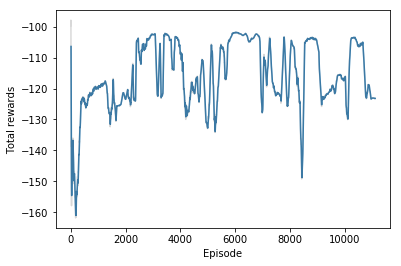

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

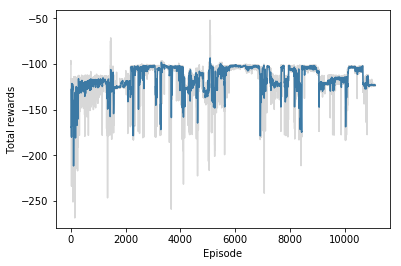

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

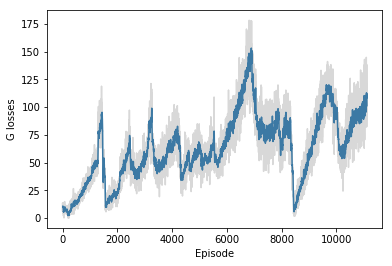

In [26]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [27]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

NameError: name 'dloss_list' is not defined

## Testing

Let's checkout how our trained agent plays the game.

In [85]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_preds = sess.run(model.actions_preds, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_preds, [-1]) # For continuous action space
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
# End the env                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -103.43347330792993


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.